# Chignolin

In [2]:
import sys
import math
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath")
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print 
from IPython.display import Markdown, display
import multiprocessing

from collections import Counter

import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

/anaconda3/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.2.
  .format(latest=latest, current=current), category=UserWarning)


## Auxiliary functions

In [3]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list, tAB_interval=None):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    if tAB_interval is not None:
        ax1.set_ylim(tAB_interval[0],tAB_interval[1])
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()

def rmsd_of_cluster(cluster, rmsd, dtraj):
    rmsd_list=[]
    for i,element in enumerate(rmsd):
        if dtraj[i] in cluster:
            rmsd_list.append(element)
    length = len(rmsd_list)
    
    if length == 0:
        return None

    return sum(rmsd_list)/length



color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']
color_sequence+=color_sequence


def cdf(pmf):
    mycdf=[]
    tot = 0
    for element in pmf:
        tot+= element
        mycdf.append(tot)
    return np.array(mycdf)



def confindence_interval_cdf(populations, totCounts, conf_interval=0.95, n_samples=100000):
    counts = np.round(np.array(populations)*totCounts)
    partialCounts = sum(counts)
    myarray = list(counts)#+[totCounts-partialCounts]
    s=np.random.dirichlet(myarray,n_samples)

    s_cdf = []

    for line in s:
        s_cdf.append(cdf(line))
    s_cdf = np.array(s_cdf)

    s = np.transpose(s)
    s_cdf = np.transpose(s_cdf)

    minval = []
    maxval = []
    minvalcdf = []
    maxvalcdf = []

    for line in s:
        sorted_line = np.sort(line)
        minval.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxval.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])

    for line in s_cdf:
        sorted_line = np.sort(line)
        minvalcdf.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxvalcdf.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])
    
    return minvalcdf[:-1], maxvalcdf[:-1]

## Reading Data

In [4]:
dtrajs = np.load("../vamp_scoring/automatic_eigenvalue/chignolin/chignolin_dtrajs_lag10ns.npy")

#unfolded
stateA = [1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 15, 16, 17, 18, 20, 22, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 45, 46, 47, 48, 49, 50, 53, 54, 56, 57, 58, 59, 61, 62, 63, 66, 67, 68, 69, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 86, 87, 89, 90, 91, 92, 93, 94, 95, 98, 99]

#folded
stateB = [0, 8, 12, 21, 23, 24, 31, 35, 39, 41, 43, 44, 52, 55, 64, 65, 70, 71, 72, 78, 84, 85]

In [5]:
len(stateA), len(stateB)

(68, 22)

In [6]:
100 - (len(stateA) + len(stateB))

10

## MSM estimation

In [11]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

### MFPTS

In [12]:
dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

## Empirical and NM (haMSM) estimates

In [12]:
def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

In [13]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 200/200
Number of A->B/B->A  events: 85/85
Number of A->B/B->A  events: 60/60
Number of A->B/B->A  events: 56/56
Number of A->B/B->A  events: 46/46
Number of A->B/B->A  events: 40/39
Number of A->B/B->A  events: 35/34
Number of A->B/B->A  events: 35/34
Number of A->B/B->A  events: 17/16
Number of A->B/B->A  events: 10/9
Number of A->B/B->A  events: 3/2
Number of A->B/B->A  events: 3/2


In [14]:
np.save('chignolin_empirical_mfptsAB', empirical_mfptsAB)
np.save('chignolin_empirical_mfptsBA', empirical_mfptsBA)
np.save('chignolin_std_errAB', std_errAB)
np.save('chignolin_std_errBA', std_errBA)
np.save('chignolin_nm_mfptsAB', nm_mfptsAB)
np.save('chignolin_nm_mfptsBA', nm_mfptsBA)
np.save('chignolin_nm_hist10ns_mfptsAB', nm_hist10ns_mfptsAB)
np.save('chignolin_nm_hist10ns_mfptsBA', nm_hist10ns_mfptsBA)
np.save('chignolin_nm_hist100ns_mfptsAB', nm_hist100ns_mfptsAB)
np.save('chignolin_nm_hist100ns_mfptsBA', nm_hist100ns_mfptsBA)

In [8]:
empirical_mfptsAB = np.load('chignolin_empirical_mfptsAB.npy')
empirical_mfptsBA = np.load('chignolin_empirical_mfptsBA.npy')
std_errAB = np.load('chignolin_std_errAB.npy')
std_errBA = np.load('chignolin_std_errBA.npy')
nm_mfptsAB = np.load('chignolin_nm_mfptsAB.npy')
nm_mfptsBA = np.load('chignolin_nm_mfptsBA.npy')
nm_hist10ns_mfptsAB = np.load('chignolin_nm_hist10ns_mfptsAB.npy')
nm_hist10ns_mfptsBA = np.load('chignolin_nm_hist10ns_mfptsBA.npy')
nm_hist100ns_mfptsAB = np.load('chignolin_nm_hist100ns_mfptsAB.npy')
nm_hist100ns_mfptsBA = np.load('chignolin_nm_hist100ns_mfptsBA.npy')

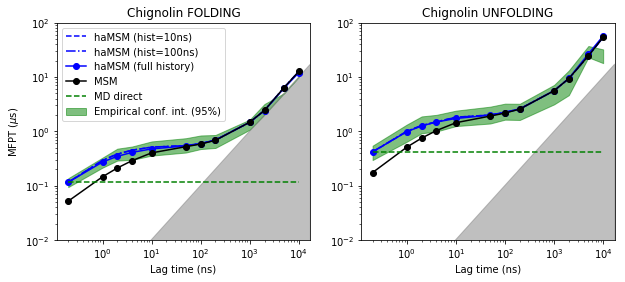

In [15]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)

plt.savefig('chignolin_mfpts.png', dpi=300)
plt.savefig('chignolin_mfpts.pdf')
plt.show()

## Markov + Color : History Analysis (Lag=1tau)

In [6]:
dt =0.0002

discrete_traj = dtrajs

history = np.array([0, 1, 10, 50, 100, 200, 300, 400, 500])
mpc_mfptsAB = []
mpc_mfptsBA = []

for hist in history:
    model = MarkovPlusColorModel(discrete_traj, stateA, stateB, hist_length=hist)
    kinetics = model.mfpts()
    mpc_mfptsAB.append(kinetics['mfptAB']*dt)
    mpc_mfptsBA.append(kinetics['mfptBA']*dt)

# Empirical values:
emp_mfpts = model.empirical_mfpts()

emp_mfptAB = emp_mfpts['mfptAB']*dt
emp_mfptBA = emp_mfpts['mfptBA']*dt
emp_std_err_mfptAB = emp_mfpts['std_err_mfptAB']*dt
emp_std_err_mfptBA = emp_mfpts['std_err_mfptBA']*dt

Number of A->B/B->A  events: 200/200


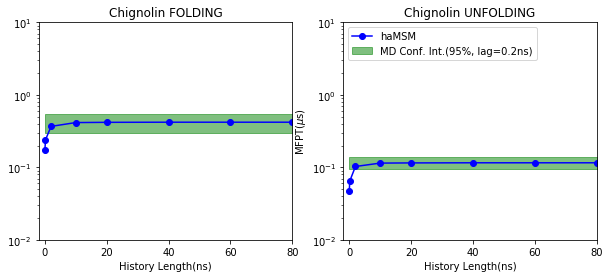

In [8]:
alpha = 0.5

fig =plt.figure(figsize = (10,4))

err_maxAB = [emp_mfptAB + 2*emp_std_err_mfptAB for _ in history]
err_minAB = [emp_mfptAB - 2*emp_std_err_mfptAB for _ in history]
err_maxBA = [emp_mfptBA + 2*emp_std_err_mfptBA for _ in history]
err_minBA = [emp_mfptBA - 2*emp_std_err_mfptBA for _ in history]



ax1 = fig.add_subplot(121)
ax1.fill_between(history*0.2, err_minBA, err_maxBA,
                 alpha=alpha, color="green", label="Conf. Int.(95%)" )
ax1.plot(history*0.2, mpc_mfptsBA, "-o", label="Markov+Color", color='b')
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("History Length(ns)")
#ax1.legend(loc='upper left')
ax1.set_xlim(-2,80)
ax1.set_ylim(0.01,10)


ax2 = fig.add_subplot(122)
ax2.fill_between(history*0.2, err_minAB, err_maxAB,
                 alpha=alpha, color="green", label="MD Conf. Int.(95%, lag=0.2ns)" )
ax2.plot(history*0.2, mpc_mfptsAB, "-o", label="haMSM", color='b')
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("History Length(ns)")
ax2.set_ylabel("MFPT($\mu$s)")
ax2.legend(loc='upper left')
ax2.set_xlim(-2,80)
ax2.set_ylim(0.01,10)

plt.savefig('chignolin_hist_analysis.png', dpi=300)
plt.savefig('chignolin_hist_analysis.pdf')

plt.show()

## First Passage Time Distribution

In [4]:
nm_model2 = NonMarkovModel(dtrajs, stateA, stateB)
nm_model2.mfpts() ## This values has to be multiplied by dt = 0.2ns

{'mfptAB': 577.4395614254604, 'mfptBA': 2096.2900843892485}

In [5]:
lag_to_use_fptd = [1, 10, 100, 1000]

In [6]:
#fptdAB = nm_model2.fpt_distrib_AB(max_x=5000, dt=0.2)  # Computes the analytic dist. up to 5000 lag times
#fptdBA = nm_model2.fpt_distrib_BA(max_x=10000, dt=0.2)
empiric_fptsAB, empiric_fptsBA, tb_values = nm_model2.empirical_fpts()

In [12]:
#Markov densities
nm_model2.markovian=True

markov_fptdAB_list=[]
markov_fptdBA_list=[]

for lag in lag_to_use_fptd:
    nm_model2.lag_time=lag
    markov_fptdAB_list.append(nm_model2.fpt_distrib_AB(max_x=5000, dt=0.2))
    markov_fptdBA_list.append(nm_model2.fpt_distrib_BA(max_x=10000, dt=0.2))

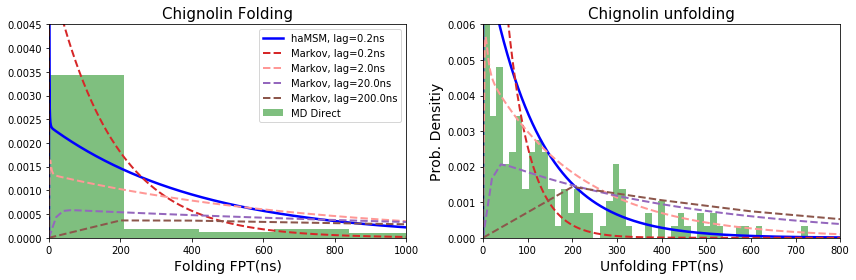

In [13]:
fig =plt.figure(figsize = (12,4))




ax1 = fig.add_subplot(121)
ax1.plot(*fptdBA.T,label='haMSM, lag=0.2ns',lw=2.5, color='b')

for i, density in enumerate(markov_fptdBA_list):
    ax1.plot(*density.T,'--', linewidth=2.0, color=color_sequence[i],
             label='Markov, lag={}ns'.format(lag_to_use_fptd[i]*0.2) )

ax1.hist(np.array(empiric_fptsBA)*0.2, normed=True, bins=20, label='MD Direct', color='green', alpha=0.5)
ax1.set_xlabel("Folding FPT(ns)", fontsize=14)
ax1.set_xlim([0,1000])
ax1.set_ylim(0,0.0045)
ax1.set_title('Chignolin Folding', fontsize=15)
ax1.legend()


ax2 = fig.add_subplot(122)
ax2.plot(*fptdAB.T,label='haMSM, lag=0.2ns', color='b',lw=2.5)

for i, density in enumerate(markov_fptdAB_list):
    ax2.plot(*density.T,'--', linewidth=2.0, color=color_sequence[i],
             label='Markov, lag={}ns'.format(lag_to_use_fptd[i]*0.2) )



ax2.hist(np.array(empiric_fptsAB)*0.2, normed=True, bins=50, label='MD Direct', color='green', alpha=0.5)
ax2.set_ylabel("Prob. Densitiy", fontsize=14)
ax2.set_xlabel("Unfolding FPT(ns)", fontsize=14)
ax2.set_xlim([0,800])
ax2.set_ylim(0,0.006)
ax2.set_title('Chignolin unfolding', fontsize=15)

fig.tight_layout()

plt.savefig('chignolin_first_pass_time_dist.png', dpi=300)
plt.savefig('chignolin_first_pass_time_dist.pdf')

plt.show()

## Event duration ($t_b$)

###  Average $t_b$ = 2.70ns

###  Median $t_b$ = 0.60ns

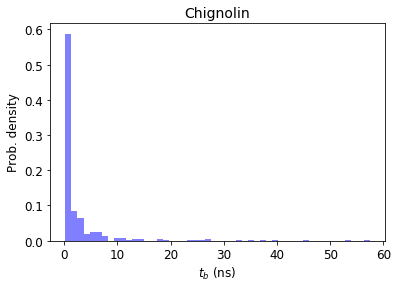

In [41]:
printmd("###  Average $t_b$ = {:.2f}ns".format(0.2*sum(tb_values)/len(tb_values)))
printmd("###  Median $t_b$ = {:.2f}ns".format(0.2*np.median(tb_values)))

plt.hist(np.array(tb_values)*0.2, normed=True, bins=50, color='blue', alpha=0.5)
plt.xlabel("$t_b$ (ns)", fontsize=12)
plt.ylabel("Prob. density", fontsize=12)
#plt.xlim([0,12])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Chignolin', fontsize=14)

plt.savefig('chignolin_event_dur.png', dpi=300)
plt.savefig('chignolin_event_dur.pdf')
plt.show()

## Correlation functions

In [19]:
nm_model = nm_model2

In [17]:
times =  range(200, 8000, 200)
times_in_us = np.array(times)*0.0002

emp_coorAB = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateB, times=times)
emp_coorAA = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateA, times=times)
emp_coorBB = nm_model.empirical_corr_function(nm_model.stateB, nm_model.stateB, times=times)

                                              LAG TIME: 0.2ns


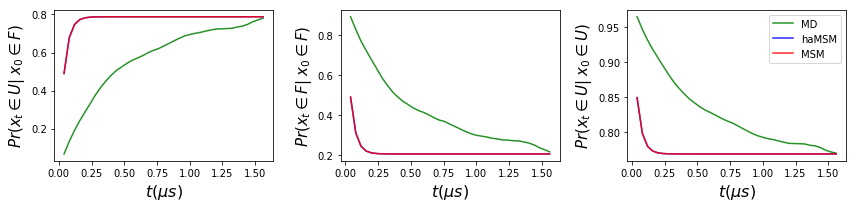

                                              LAG TIME: 2.0ns


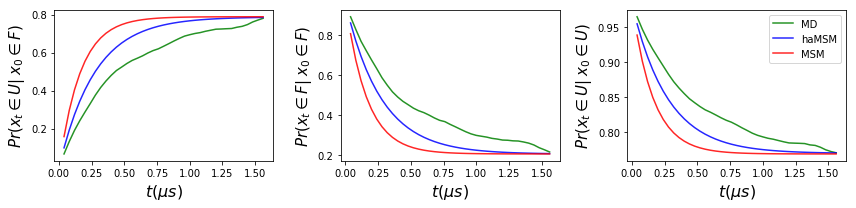

                                              LAG TIME: 10.0ns


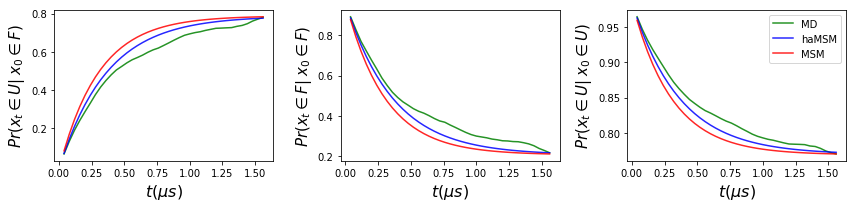

                                              LAG TIME: 20.0ns


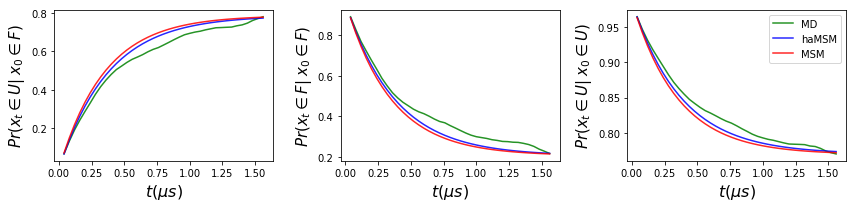

                                              LAG TIME: 40.0ns


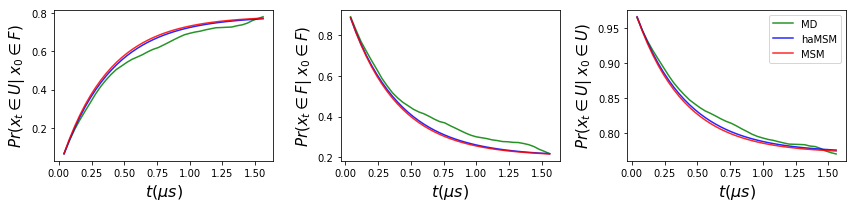

In [20]:
pA = nm_model.popA
pB = nm_model.popB

alpha = 0.85

for lag in [1, 10, 50, 100, 200]:

    nm_model.lag_time=lag
    print(46*' ' + 'LAG TIME: {}ns'.format(lag*0.2))

    nm_pAA, nm_pAB, nm_pBA, nm_pBB = nm_model.corr_function(times=times)
    
    nm_model.markovian = True
    msm_pAA, msm_pAB, msm_pBA, msm_pBB = nm_model.corr_function(times=times)
    nm_model.markovian = False

    fig = plt.figure(figsize=(12,3))
    fig.add_subplot(131)
    plt.plot(times_in_us, emp_coorAB/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAB/pA, label='haMSM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAB/pA, label='MSM', color='red', alpha=alpha)
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in U|\; x_0 \in F)$', fontsize=15)

    fig.add_subplot(132)
    plt.plot(times_in_us, emp_coorAA/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAA/pA, label='haMSM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAA/pA, label='MSM', color='red', alpha=alpha)
    
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in F|\; x_0 \in F)$', fontsize=15)
    
    fig.add_subplot(133)
    plt.plot(times_in_us, emp_coorBB/pB, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pBB/pB, label='haMSM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pBB/pB, label='MSM', color='red', alpha=alpha )
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in U|\; x_0 \in U)$', fontsize=15)
    plt.legend(loc='upper right')

    fig.tight_layout()
    
    plt.savefig('chignolin_corr_funct_%d.png' % lag, dpi=300)
    plt.savefig('chignolin_corr_funct_%d.pdf' % lag)

    plt.show()

In [ ]:
# not sure why lag 0.2 ns is missing the haMSM...

## Fundamental Sequences
### Building the model

For the calculation of the fundamental sequences the microstates inside every macrostate (A and B) 
are merged together. Then the sates A and B are not longer composed by multiple microstates but by a 
single (big) one. 

In [25]:
nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)
m_p_color = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True, hist_length=100)

### Obtaining the FSs

In [26]:
mdFS, mdFSweights, tot_count_md = nm_model.empirical_weighted_FS()

nmFS, nmFSweights, _ = nm_model.weighted_FS()
mcFS, mcFSweights, _ = m_p_color.weighted_FS()



nm_model.markovian = True
msmFS, msmFSweights, _ = nm_model.weighted_FS() # lag=1

nm_model.lag_time = 10
msmFS_10, msmFSweights_10, _ = nm_model.weighted_FS() # lag=10

nm_model.lag_time = 50
msmFS_50, msmFSweights_50, _ = nm_model.weighted_FS()

nm_model.lag_time = 125
msmFS_125, msmFSweights_125, _ = nm_model.weighted_FS()

nm_model.lag_time = 250
msmFS_250, msmFSweights_250, _ = nm_model.weighted_FS()

nm_model.lag_time = 500
msmFS_500, msmFSweights_500, _ = nm_model.weighted_FS()

nm_model.lag_time = 1000
msmFS_1000, msmFSweights_1000, _ = nm_model.weighted_FS() # lag=1000


nm_model.lag_time = 1

nm_model.markovian = False

In [27]:
### Comparing apples to apples

In [28]:
nmFSweights_temp = []
mcFSweights_temp = []

msmFSweights_temp = []
msmFSweights_temp_10 = []
msmFSweights_temp_50 = []
msmFSweights_temp_125 = []
msmFSweights_temp_250 = []
msmFSweights_temp_500 = []

msmFSweights_temp_1000 = []

for i, element in enumerate(mdFS):
    
    # lag=1
    if element in nmFS:
        nmFSweights_temp.append(nmFSweights[nmFS.index(element)])
    else:
        nmFSweights_temp.append(0)
    
    if element in msmFS:
        msmFSweights_temp.append(msmFSweights[msmFS.index(element)])
    else:
        msmFSweights_temp.append(0)
    
    if element in mcFS:
        mcFSweights_temp.append(mcFSweights[mcFS.index(element)])
    else:
        mcFSweights_temp.append(0)
    
    # lag=10
    if element in msmFS_10:
        msmFSweights_temp_10.append(msmFSweights_10[msmFS_10.index(element)])
    else:
        msmFSweights_temp_10.append(0)
    
    # lag=50
    if element in msmFS_50:
        msmFSweights_temp_50.append(msmFSweights_50[msmFS_50.index(element)])
    else:
        msmFSweights_temp_50.append(0)
        
    # lag=125
    if element in msmFS_125:
        msmFSweights_temp_125.append(msmFSweights_125[msmFS_125.index(element)])
    else:
        msmFSweights_temp_125.append(0)
        
    # lag=50
    if element in msmFS_250:
        msmFSweights_temp_250.append(msmFSweights_250[msmFS_250.index(element)])
    else:
        msmFSweights_temp_250.append(0)
        
    # lag=50
    if element in msmFS_500:
        msmFSweights_temp_500.append(msmFSweights_500[msmFS_500.index(element)])
    else:
        msmFSweights_temp_500.append(0)    
    
    # lag=1000
    if element in msmFS_1000:
        msmFSweights_temp_1000.append(msmFSweights_1000[msmFS_1000.index(element)])
    else:
        msmFSweights_temp_1000.append(0)


In [29]:
mdmin, mdmax = confindence_interval_cdf(mdFSweights, tot_count_md)

### Plot

#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton

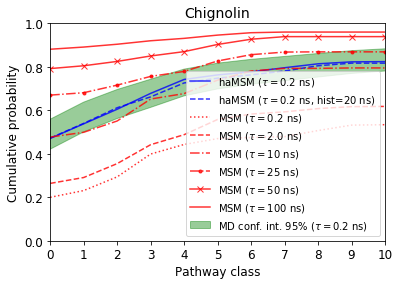

In [42]:
printmd("#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton")

alpha=0.8
x = list( range(len(mdFS)) )

plt.fill_between(x[:-1], mdmin, mdmax, color='green', alpha=0.4, label=r'MD conf. int. 95% ($\tau=0.2$ ns)')
plt.plot(x, cdf(nmFSweights_temp), label = r'haMSM ($\tau=0.2$ ns)', color='blue', alpha=alpha)
plt.plot(x, cdf(mcFSweights_temp), '--',label = r'haMSM ($\tau=0.2$ ns, hist=20 ns)', color='blue', alpha=alpha)

plt.plot(x, cdf(msmFSweights_temp),':', label = r'MSM ($\tau=0.2$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_10),'--', label = r'MSM ($\tau=2.0$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_50),'-.', label = r'MSM ($\tau=10$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_125),'-..', label = r'MSM ($\tau=25$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_250),'-x', label = r'MSM ($\tau=50$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_500),'c', label = r'MSM ($\tau=100$ ns)', color='red', alpha=alpha)
#plt.plot(x, cdf(msmFSweights_temp_1000),'-', label = r'MSM ($\tau=200$ns)', color='red', alpha=alpha)


plt.xticks([i for i in range(0,2*len(mdFS),1)], fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,10])
plt.ylim([0,1.0])
plt.xlabel('Pathway class', fontsize=12)
plt.ylabel('Cumulative probability', fontsize=12)

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()

plt.title('Chignolin', fontsize=14)

#plt.tight_layout()
plt.savefig('chignolin_FS.png', dpi=300)
plt.savefig('chignolin_FS.pdf')

plt.show()

# # Plot without MSM
# plt.fill_between(x[:-1], mdmin, mdmax, color='green', alpha=0.4, label=r'MD Conf. Int. 95% ($\tau=0.2$ns)')
# plt.plot(x, cdf(nmFSweights_temp), label = r'haMSM ($\tau=0.2$ns)', color='blue', alpha=alpha)
# plt.plot(x, cdf(mcFSweights_temp), '--',label = r'haMSM ($\tau=0.2$ns, hist=20ns)', color='blue', alpha=alpha)


# plt.xticks([i for i in range(0,2*len(mdFS),1)])
# plt.xlim([0,10])
# plt.ylim([0,1.0])
# plt.xlabel('Pathway Class', fontsize=14)
# plt.ylabel('Cumulative Probability', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.show()

#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton

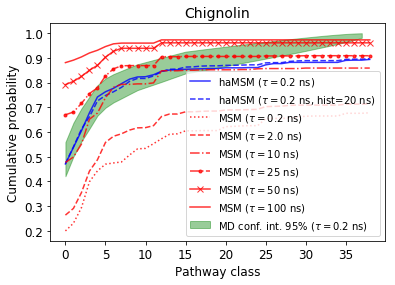

In [43]:
printmd("#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton")

alpha=0.8
x = list( range(len(mdFS)) )

plt.fill_between(x[:-1], mdmin, mdmax, color='green', alpha=0.4, label=r'MD conf. int. 95% ($\tau=0.2$ ns)')
plt.plot(x, cdf(nmFSweights_temp), label = r'haMSM ($\tau=0.2$ ns)', color='blue', alpha=alpha)
plt.plot(x, cdf(mcFSweights_temp), '--',label = r'haMSM ($\tau=0.2$ ns, hist=20 ns)', color='blue', alpha=alpha)

plt.plot(x, cdf(msmFSweights_temp),':', label = r'MSM ($\tau=0.2$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_10),'--', label = r'MSM ($\tau=2.0$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_50),'-.', label = r'MSM ($\tau=10$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_125),'-..', label = r'MSM ($\tau=25$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_250),'-x', label = r'MSM ($\tau=50$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_500),'c', label = r'MSM ($\tau=100$ ns)', color='red', alpha=alpha)
#plt.plot(x, cdf(msmFSweights_temp_1000),'-', label = r'MSM ($\tau=200$ns)', color='red', alpha=alpha)


#plt.xticks([i for i in range(0,2*len(mdFS),1)])
#plt.xlim([0,10])
#plt.ylim([0,1.0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Pathway class', fontsize=12)
plt.ylabel('Cumulative probability', fontsize=12)

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()

plt.title('Chignolin', fontsize=14)

#plt.tight_layout()
plt.savefig('chignolin_FS_full.png', dpi=300)
plt.savefig('chignolin_FS_full.pdf')

plt.show()

# # Plot without MSM
# plt.fill_between(x[:-1], mdmin, mdmax, color='green', alpha=0.4, label=r'MD Conf. Int. 95% ($\tau=0.2$ns)')
# plt.plot(x, cdf(nmFSweights_temp), label = r'haMSM ($\tau=0.2$ns)', color='blue', alpha=alpha)
# plt.plot(x, cdf(mcFSweights_temp), '--',label = r'haMSM ($\tau=0.2$ns, hist=20ns)', color='blue', alpha=alpha)


# plt.xticks([i for i in range(0,2*len(mdFS),1)])
# plt.xlim([0,10])
# plt.ylim([0,1.0])
# plt.xlabel('Pathway Class', fontsize=14)
# plt.ylabel('Cumulative Probability', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.show()

# Mechanisms in a simpler way -- simulate trajs, count how often microstates hit

In [8]:
from collections import Counter

In [9]:
# empirical

In [108]:
macro_traj = []

for micro in dtrajs[0]:
    if micro in stateA:
        macro_traj.append(0)
    elif micro in stateB:
        macro_traj.append(2)
    else:
        macro_traj.append(1)
        
dtrajs_macro = macro_traj        

In [11]:
len(macro_traj)

534743

In [12]:
# macro_traj = dtrajs_macro

In [13]:
# plt.figure(dpi=300)
# plt.plot(dtrajs_macro)

In [14]:
# plt.figure(dpi=300)
# plt.scatter(range(len(macro_traj[::10])),macro_traj[::10],s=5)
# plt.show()

In [109]:
traj = dtrajs[0]
int_trajs = []

int_traj = []
in_int = False
int_start = None
int_end = None
for i in range(len(macro_traj) - 1):
    if in_int:
        int_traj.append(traj[i])
        if macro_traj[i+1] in [0,2]:
            in_int = False
            int_end = macro_traj[i+1]
            if int_end != int_start:
                int_trajs.append(int_traj)
            int_traj = []
    elif macro_traj[i] != macro_traj[i+1]:
        if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
            in_int = True
            int_start = macro_traj[i]     

In [110]:
len(int_trajs)

210

In [128]:
# let's see how many occurences there are of no-intermediate transitions

In [129]:
traj = dtrajs[0]
count = 0

for i in range(len(macro_traj) - 1):
    if macro_traj[i] != macro_traj[i+1]:
        if macro_traj[i] in [0,2] and macro_traj[i+1] in [0,2]:
            count += 1    

In [130]:
count

190

In [133]:
210/(190+210) # 52.5% transitions go through intermediates

0.525

In [567]:
lens = []

for traj in int_trajs:
    lens.append(len(traj))

In [362]:
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

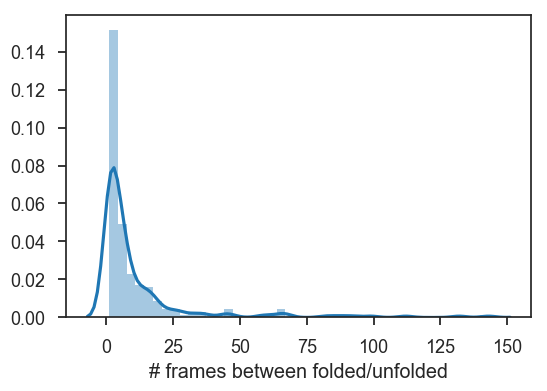

In [569]:
plt.figure(dpi=100)
sns.distplot(lens)
plt.xlabel('# frames between folded/unfolded')
plt.show()

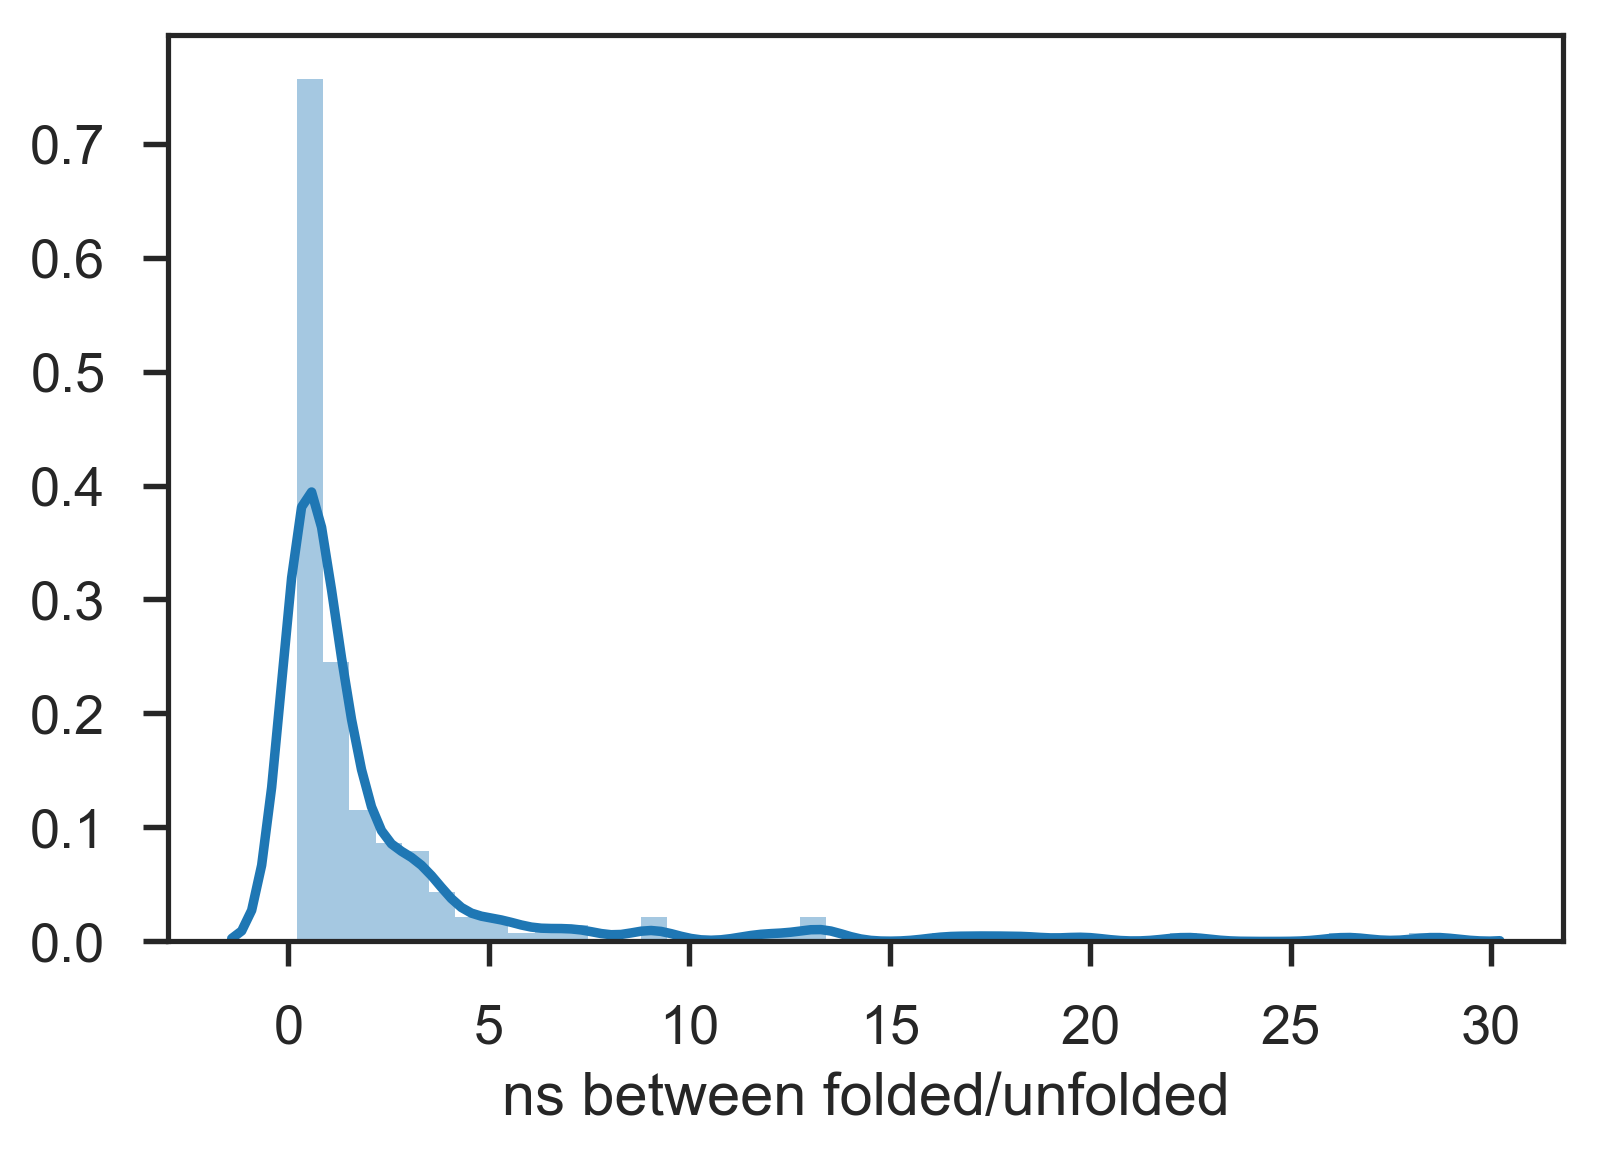

In [572]:
plt.figure(dpi=300)
sns.distplot(np.array(lens)*0.2)
plt.xlabel('ns between folded/unfolded')
plt.show()

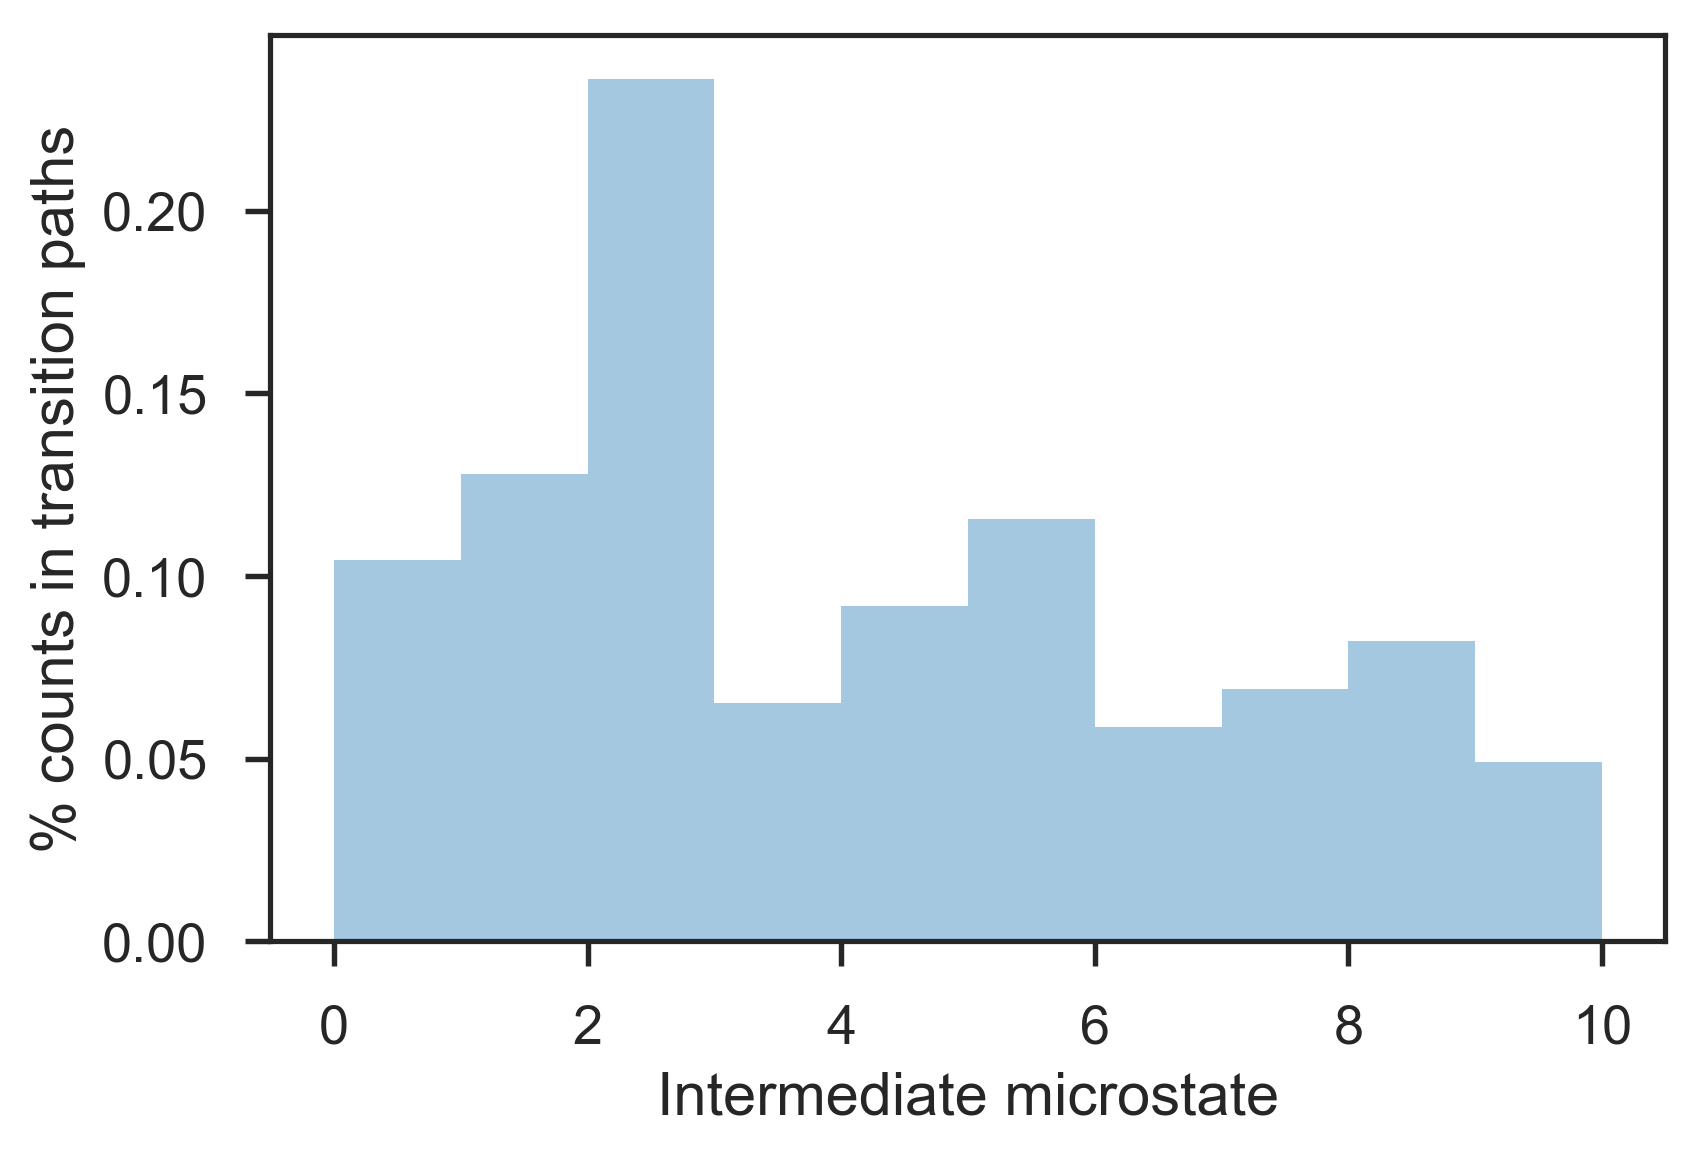

In [577]:
plt.figure(dpi=300)
sns.distplot([np.argwhere(np.sort(list(set(np.concatenate(int_trajs)))) == i)[0,0] for i in np.concatenate(int_trajs)], kde=False, bins=range(11), norm_hist=True)
plt.xlabel('Intermediate microstate')
plt.ylabel('% counts in transition paths')
plt.show()

In [17]:
boostrap_counts = []

int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

for boostrap in range(100):

    int_trajs_ = np.random.choice(int_trajs, 210)

    counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_)])
    
    counts = [counter[i] for i in range(10)]

    counts = counts / np.sum(counts)
    
    boostrap_counts.append(counts)
    
    print(boostrap)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


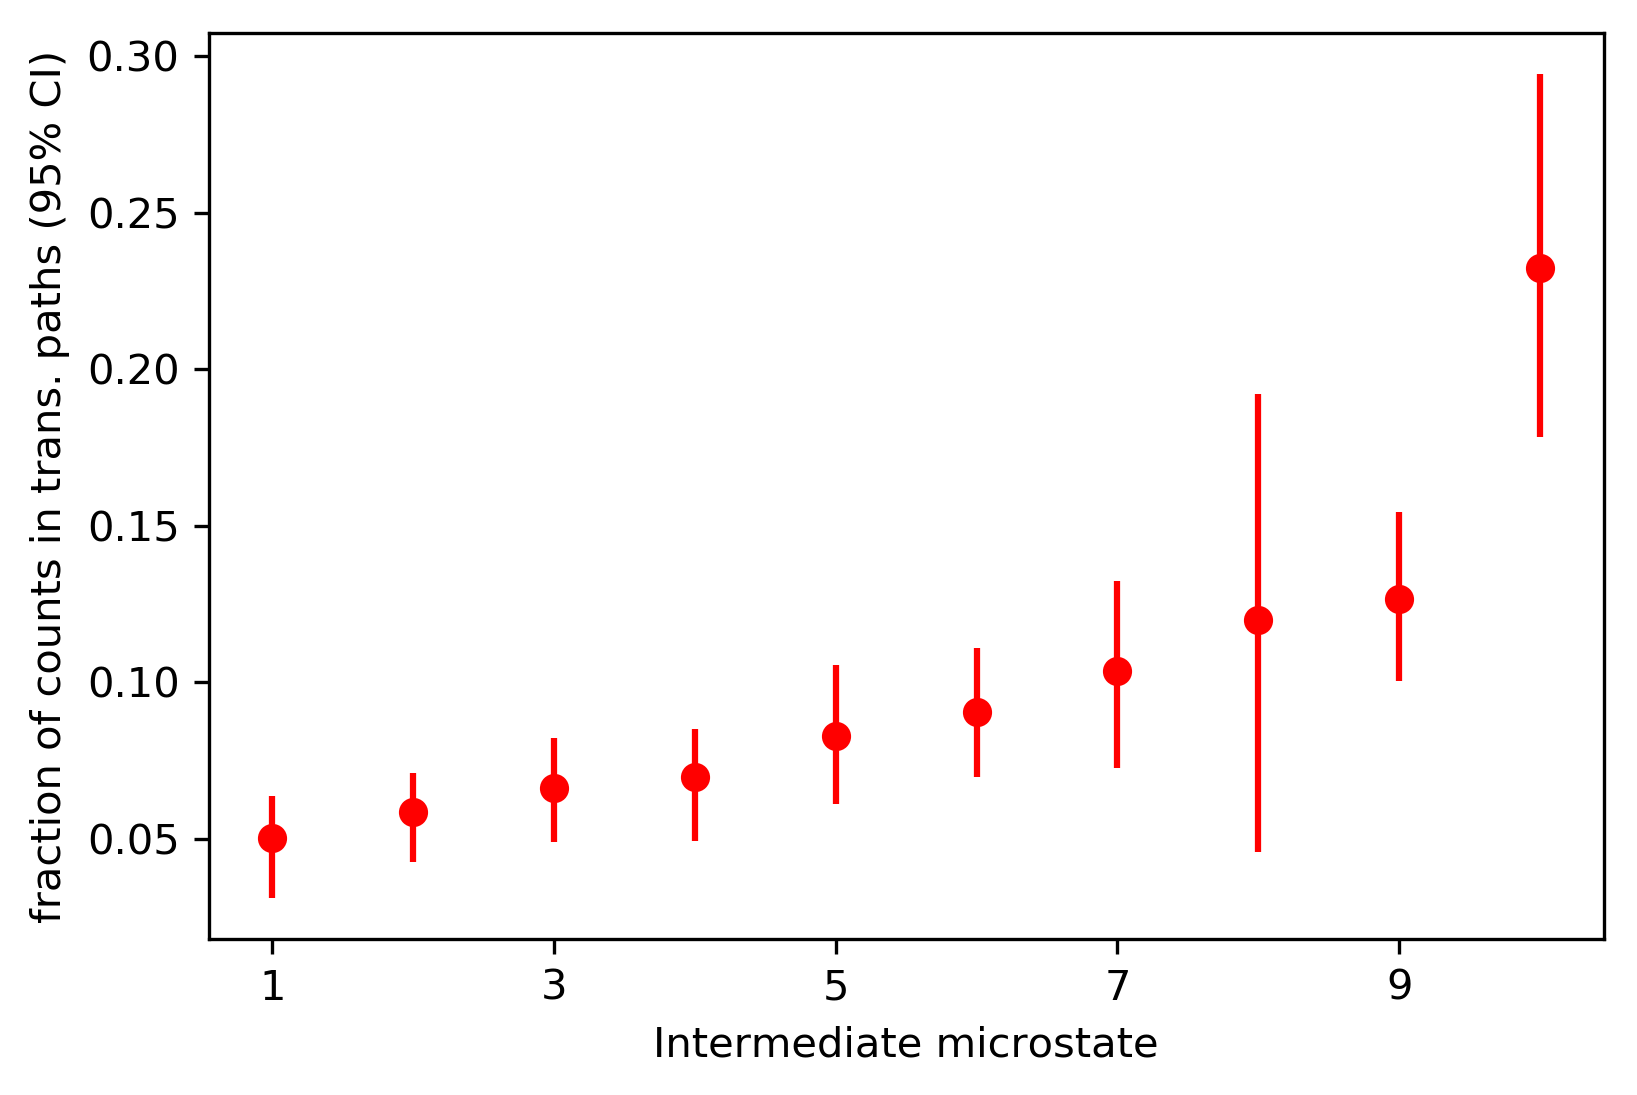

In [71]:
plt.figure(dpi=300)
plt.scatter(range(10), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='red')
plt.errorbar(range(10), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[(np.percentile(boostrap_counts, 95, axis=0)-np.mean(boostrap_counts, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))], (np.mean(boostrap_counts, axis=0)-np.percentile(boostrap_counts, 5, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='red')
plt.xlabel('Intermediate microstate')
plt.ylabel('fraction of counts in trans. paths (95% CI)')
plt.xticks(np.arange(0,9,2), np.arange(1,10,2))
plt.show()

In [582]:
int_trajs_emp = int_trajs

In [366]:
##### MSMs #####

In [7]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

In [97]:
# int_trajs_all = []

# for msm_index in range(9):
    
#     int_trajs = []
    
#     traj = msm[msm_index].simulate(np.int(534743 / lags[msm_index])) # same length as original traj

#     macro_traj = []

#     for micro in traj:
#         if micro in stateA:
#             macro_traj.append(0)
#         elif micro in stateB:
#             macro_traj.append(2)
#         else:
#             macro_traj.append(1)

#     transition = False

#     if len(set(macro_traj)) == 3:
#         transition = True

#     # now get the fragments of trajectories in intermediate states after event and before another

#     if transition:
#         int_traj = []
#         in_int = False
#         int_start = None
#         int_end = None
#         for i in range(len(macro_traj) - 1):
#             if in_int:
#                 int_traj.append(traj[i])
#                 if macro_traj[i+1] in [0,2]:
#                     in_int = False
#                     int_end = macro_traj[i+1]
#                     if int_end != int_start:
#                         int_trajs.append(int_traj)
#                     int_traj = []
#             elif macro_traj[i] != macro_traj[i+1]:
#                 if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
#                     in_int = True
#                     int_start = macro_traj[i]
                        
#     int_trajs_all.append(int_trajs)
    
#     print(msm_index)
#     print(len(int_trajs))

In [30]:
int_trajs_all = []

for msm_index in range(9):
    
    print('lag: %d' % lags[msm_index])
    
    count = 0

    int_trajs = []

    while len(int_trajs) < 1000:
    #for i in range(1):
        #traj = msm[msm_index].simulate(np.int(50000 / lags[msm_index])) # 10 microsecond always
        #traj = msm[msm_index].simulate(np.int(1000000 / lags[msm_index])) # one long trajectory, 1 million steps -- 2x the original traj
        traj = msm[msm_index].simulate(np.int(100000)) # always same number of steps
        macro_traj = []

        for micro in traj:
            if micro in stateA:
                macro_traj.append(0)
            elif micro in stateB:
                macro_traj.append(2)
            else:
                macro_traj.append(1)

        transition = False

        if len(set(macro_traj)) == 3:
            transition = True

        if transition:
            count += 1
            
        #print(count)

        # now get the fragments of trajectories in intermediate states after event and before another

        if transition:
            int_traj = []
            in_int = False
            int_start = None
            int_end = None
            for i in range(len(macro_traj) - 1):
                if in_int:
                    int_traj.append(traj[i])
                    if macro_traj[i+1] in [0,2]:
                        in_int = False
                        int_end = macro_traj[i+1]
                        if int_end != int_start:
                            int_trajs.append(int_traj)
                        int_traj = []
                elif macro_traj[i] != macro_traj[i+1]:
                    if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                        in_int = True
                        int_start = macro_traj[i]
                        
        print(len(int_trajs))              

    int_trajs_all.append(int_trajs)

lag: 1
159
313
460
626
779
925
1070
lag: 5
212
478
682
910
1150
lag: 10
305
629
947
1247
lag: 20
410
808
1225
lag: 50
554
1121
lag: 250
859
1683
lag: 500
837
1738
lag: 1000
945
1981
lag: 5000
816
1715


In [31]:
[len(x) for x in int_trajs_all]

[1070, 1150, 1247, 1225, 1121, 1683, 1738, 1981, 1715]

In [39]:
# counts_all = []

# for msm_index in range(9):

#     counter = Counter([np.argwhere(np.sort(list(set(np.concatenate(int_trajs_all[msm_index])))) == i)[0,0] for i in np.concatenate(int_trajs_all[msm_index])])
#     counts = [counter[i] for i in range(10)]
#     counts = np.array(counts) / np.sum(counts)

#     counts = counts - counts_emp

#     counts_all.append(counts)

In [949]:
# norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
# cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
# cmap.set_array([])

# plt.figure(dpi=300)
# for msm_index in range(9):
#     #plt.plot(np.arange(10), counts_all[msm_index][np.argsort(counts_emp)], color=cmap.to_rgba(msm_index))
#     plt.scatter(np.arange(10), counts_all[msm_index][np.argsort(counts_emp)]*100, color=cmap.to_rgba(msm_index), s=50)
#     #plt.plot(np.arange(10), counts_all[msm_index], color=cmap.to_rgba(msm_index))
# #plt.plot(counts_emp[np.argsort(counts_emp)], c='black')    
# plt.xlabel('Intermediate microstate')
# plt.ylabel('% counts in trans. paths (- MD)')
# cbar = plt.colorbar(cmap)
# cbar.set_ticks(range(9))
# cbar.set_ticklabels(lags[:9]*0.2)
# cbar.set_label('Lag time/ns')
# plt.hlines(0, 0, 9, color='red')
# plt.show()

In [32]:
# ABSOLUTE, SHOW EMPIRICAL ERRORS

counts_all = []

int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

for msm_index in range(9):

    counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_all[msm_index])])
    counts = [counter[i] for i in range(10)]
    counts = np.array(counts) / np.sum(counts)

    counts_all.append(counts)

In [935]:
# plt.figure(dpi=300)

# norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
# cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
# cmap.set_array([])

# for msm_index in range(9):
#     plt.scatter(np.arange(0.1+0.2*msm_index/2-0.1,10.1+0.2*msm_index/2-0.1), counts_all[msm_index][np.argsort(counts_emp)], color=cmap.to_rgba(msm_index), s=50)

# cbar = plt.colorbar(cmap)
# cbar.set_ticks(range(9))
# cbar.set_ticklabels(lags[:9]*0.2)
# cbar.set_label('Lag time/ns')

# plt.scatter(range(10), np.mean(boostrap_counts, axis=0)[np.argsort(counts_emp)], color='red')
# plt.errorbar(range(10), np.mean(boostrap_counts, axis=0)[np.argsort(counts_emp)], yerr=[np.percentile(boostrap_counts, 0.05, axis=0)[np.argsort(counts_emp)], np.percentile(boostrap_counts, 0.95, axis=0)[np.argsort(counts_emp)]], fmt='none', color='red')
# plt.xlabel('intermediate microstate')
# plt.ylabel('fraction of counts in trans. paths (95% CI)')
# plt.xticks(np.arange(0,9,2), np.arange(1,10,2))
# plt.yticks(np.arange(0, 0.5, 0.1))

# plt.show()

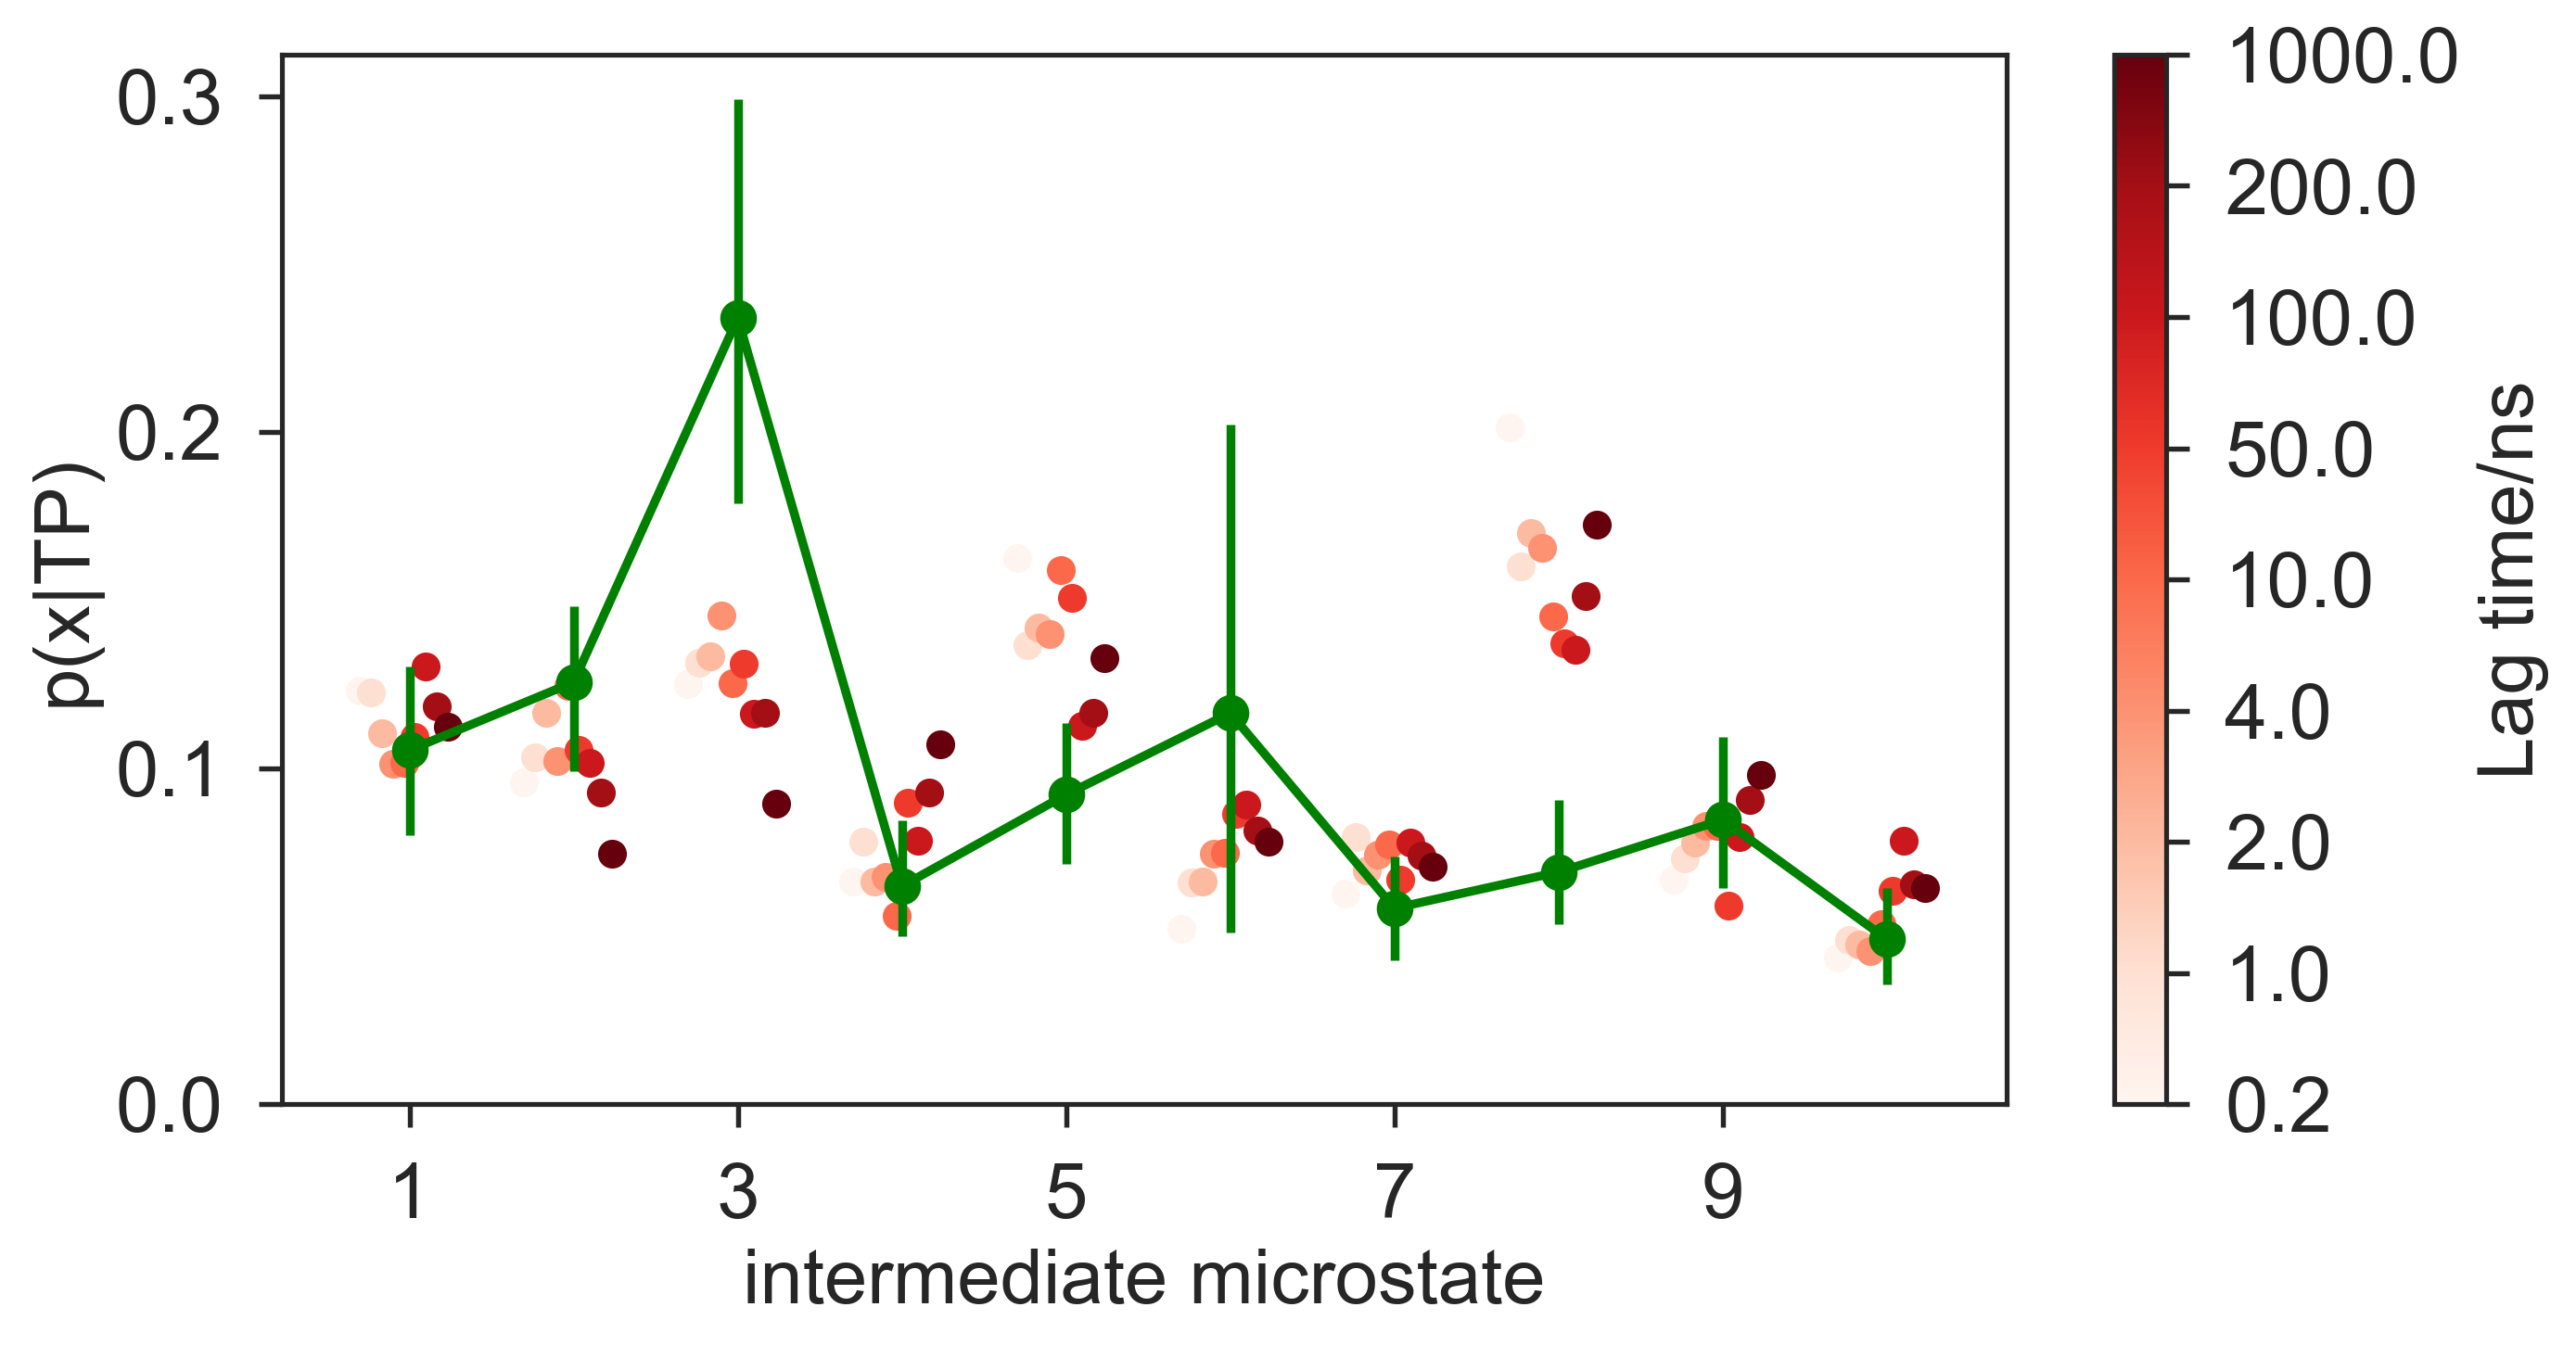

In [50]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    #plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index][np.argsort(np.mean(boostrap_counts, axis=0))], color=cmap.to_rgba(msm_index), s=50)
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('Lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.scatter(range(1,11), np.mean(boostrap_counts, axis=0), color='green')
plt.plot(range(1,11), np.mean(boostrap_counts, axis=0), color='green')
plt.errorbar(range(1,11), np.mean(boostrap_counts, axis=0), yerr=[(np.mean(boostrap_counts, axis=0)-np.percentile(boostrap_counts, 5, axis=0)), (np.percentile(boostrap_counts, 95, axis=0)-np.mean(boostrap_counts, axis=0))], fmt='none', color='green')
plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0, 0.4, 0.1), fontsize=20)
#plt.ylim(0,0.3)

plt.show()

In [67]:
Counter([len(x) for x in int_trajs_all[6]]) # 100 ns

Counter({1: 1636, 2: 95, 3: 6, 4: 1})

In [691]:
# plt.figure(dpi=300)

# norm = matplotlib.colors.Normalize(vmin=0, vmax=13)
# cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Blues)
# cmap.set_array([])

# for msm_index in range(9):
#     if msm_index > 4:
#         plt.scatter(np.arange(10), counts_all[msm_index][np.argsort(counts_emp)], color=cmap.to_rgba(msm_index+5), s=50)
#     else:
#         plt.scatter(np.arange(10), counts_all[msm_index][np.argsort(counts_emp)], color=cmap.to_rgba(msm_index), s=50)

# cbar = plt.colorbar(cmap)
# cbar.set_ticks(list(range(5))+list(range(10,14)))
# cbar.set_ticklabels(list(lags[:5]*0.2) + list(lags[5:]*0.2))
# cbar.set_label('Lag time/ns')

# plt.scatter(range(10), np.mean(boostrap_counts, axis=0)[np.argsort(counts_emp)], color='red')
# plt.errorbar(range(10), np.mean(boostrap_counts, axis=0)[np.argsort(counts_emp)], yerr=[np.percentile(boostrap_counts, 0.05, axis=0)[np.argsort(counts_emp)], np.percentile(boostrap_counts, 0.95, axis=0)[np.argsort(counts_emp)]], fmt='none', color='red')
# plt.xlabel('intermediate microstate')
# plt.ylabel('fraction of counts in trans. paths (95% CI)')
# plt.xticks(np.arange(0,9,2), np.arange(1,10,2))

# plt.show()

In [715]:
# plt.figure(dpi=300)

# norm = matplotlib.colors.Normalize(vmin=np.log10(np.min(lags[:9])), vmax=np.log10(np.max(lags[:9])))
# cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Blues)
# cmap.set_array([])

# for msm_index in range(9):
#     plt.scatter(np.arange(10), counts_all[msm_index][np.argsort(counts_emp)], color=cmap.to_rgba(np.log10(lags[msm_index])), s=50)

# cbar = plt.colorbar(cmap)
# cbar.set_ticks([np.log10(i) for i in lags[:9]])
# cbar.set_ticklabels(lags[:9]*0.2)
# cbar.set_label('lag time/ns')

# plt.scatter(range(10), np.mean(boostrap_counts, axis=0)[np.argsort(counts_emp)], color='red')
# plt.errorbar(range(10), np.mean(boostrap_counts, axis=0)[np.argsort(counts_emp)], yerr=[np.percentile(boostrap_counts, 0.05, axis=0)[np.argsort(counts_emp)], np.percentile(boostrap_counts, 0.95, axis=0)[np.argsort(counts_emp)]], fmt='none', color='red')
# plt.xlabel('intermediate microstate')
# plt.ylabel('fraction of counts in trans. paths (95% CI)')
# plt.xticks(np.arange(0,9,2), np.arange(1,10,2))

# plt.show()

In [803]:
# see the other quantity now - don't count a microstate multiple times within a path, only once per path

In [ ]:
# BELOW ALL YOU NEED FOR A CALCULATION AND PLOT - left with multiple counts commented out, after changed to one count

In [ ]:
# boostrap_counts = []

# for boostrap in range(10):

#     int_trajs_ = np.random.choice(int_trajs, 210)

#     counts = [Counter([np.argwhere(np.sort(list(set(np.concatenate(int_trajs_)))) == i)[0,0] for i in np.concatenate(int_trajs_)])[i] for i in range(10)]

#     counts = counts / np.sum(counts)
    
#     boostrap_counts.append(counts)
    
#     print(boostrap)

In [ ]:
# counts_all = []

# for msm_index in range(9):

#     counter = Counter([np.argwhere(np.sort(list(set(np.concatenate(int_trajs_all[msm_index])))) == i)[0,0] for i in np.concatenate(int_trajs_all[msm_index])])
#     counts = [counter[i] for i in range(10)]
#     counts = np.array(counts) / np.sum(counts)

#     counts_all.append(counts)

In [ ]:
# plt.figure(dpi=300, figsize=(10,5))

# norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
# cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
# cmap.set_array([])

# for msm_index in range(9):
#     plt.scatter(np.arange(0.625+0.25*msm_index/3,10.5), counts_all[msm_index][np.argsort(np.mean(boostrap_counts, axis=0))], color=cmap.to_rgba(msm_index), s=50)

# cbar = plt.colorbar(cmap)
# cbar.set_ticks(range(9))
# cbar.set_ticklabels(lags[:9]*0.2)
# cbar.set_label('Lag time/ns', fontsize=20)
# cbar.ax.tick_params(labelsize=20)

# plt.scatter(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='red')
# plt.errorbar(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[np.percentile(boostrap_counts, 0.05, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], np.percentile(boostrap_counts, 0.95, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='red')
# plt.xlabel('intermediate microstate', fontsize=20)
# plt.ylabel('fraction of counts in trans. paths (95% CI)', fontsize=20)
# plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
# plt.yticks(np.arange(0, 0.5, 0.1), fontsize=20)

# plt.show()

In [104]:
# boostrap_counts = []

# int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

# for boostrap in range(100):

#     int_trajs_ = np.random.choice(int_trajs, 210)
    
#     int_trajs_ = [list(set(x)) for x in int_trajs_]

#     counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_)])
    
#     counts = [counter[i] for i in range(10)]

#     counts = counts / np.sum(counts)
    
#     boostrap_counts.append(counts)
    
#     print(boostrap)

In [52]:
# int_trajs_all_ = []

# for x in int_trajs_all:
#     int_trajs_all_.append([list(set(traj)) for traj in x])    
    
# counts_all = []

# int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

# for msm_index in range(9):

#     counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_all_[msm_index])])
#     counts = [counter[i] for i in range(10)]
#     counts = np.array(counts) / np.sum(counts)

#     counts_all.append(counts)    

In [105]:
# fig = plt.figure(dpi=300, figsize=(10,5))
# fig.patch.set_facecolor('white')

# norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
# cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Blues)
# cmap.set_array([])

# for msm_index in range(9):
#     plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index][np.argsort(np.mean(boostrap_counts, axis=0))], color=cmap.to_rgba(msm_index), s=50)

# cbar = plt.colorbar(cmap)
# cbar.set_ticks(range(9))
# cbar.set_ticklabels(lags[:9]*0.2)
# cbar.set_label('Lag time/ns', fontsize=20)
# cbar.ax.tick_params(labelsize=20)

# plt.scatter(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='red')
# plt.errorbar(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[(np.percentile(boostrap_counts, 95, axis=0)-np.mean(boostrap_counts, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))], (np.mean(boostrap_counts, axis=0)-np.percentile(boostrap_counts, 5, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='red')
# plt.xlabel('intermediate microstate', fontsize=20)
# plt.ylabel('p(x | TP)', fontsize=20)
# plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
# plt.yticks(np.arange(0, 0.5, 0.1), fontsize=20)

# plt.show()

In [817]:
# I wonder what happens to statistics if I change the number of intermediate states

In [818]:
chignolin_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/chignolin_lag150ns_metastable_memberships.npy')

villin_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/villin_lag100ns_metastable_memberships_3states.npy')
villin_misfold = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/villin_misfold.npy')

trpcage_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/trpcage_lag100ns_metastable_memberships.npy')

ntl9_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/ntl9_lag200ns_metastable_memberships.npy')

In [819]:
# returns [[folded], [unfolded], [intermediate]]
def get_sets(cutoff):
    chignolin_sets = [np.concatenate(np.argwhere(chignolin_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(chignolin_membs[:,0] >= cutoff)), []]
    
    for i in range(100):
        if i not in chignolin_sets[0] and i not in chignolin_sets[1]:
            chignolin_sets[2].append(i)
    
    villin_sets = [np.concatenate(np.argwhere(villin_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(villin_membs[:,2] >= cutoff)), []]
    
    for i in range(100):
        if i not in villin_sets[0] and i not in villin_sets[1] and i not in villin_misfold:
            villin_sets[2].append(i)

    trpcage_sets = [np.concatenate(np.argwhere(trpcage_membs[:,0] >= cutoff)),
    np.concatenate(np.argwhere(trpcage_membs[:,1] >= cutoff)), []]
    
    for i in range(100):
        if i not in trpcage_sets[0] and i not in trpcage_sets[1]:
            trpcage_sets[2].append(i)

    ntl9_sets = [np.concatenate(np.argwhere(ntl9_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(ntl9_membs[:,0] >= cutoff)), []]
    
    for i in range(100):
        if i not in ntl9_sets[0] and i not in ntl9_sets[1]:
            ntl9_sets[2].append(i)
    
    return (chignolin_sets, villin_sets, trpcage_sets, ntl9_sets)

In [820]:
intermediate_lens = []

for cutoff in (list(np.arange(0.5, 0.85, 0.05)) + list(np.arange(0.85, 0.95, 0.005)) + list(np.arange(0.95, 0.99, 0.01)) + list(np.arange(0.99, 0.999, 0.001))):

    stateA = get_sets(cutoff)[0][1] # unfolded
    stateB = get_sets(cutoff)[0][0]
    
    intermediate_lens.append(100 - (len(stateA)+len(stateB)))

In [826]:
len(intermediate_lens)

42

In [834]:
intermediate_lens

[0,
 1,
 2,
 3,
 3,
 4,
 7,
 9,
 9,
 9,
 10,
 10,
 11,
 12,
 13,
 15,
 19,
 21,
 24,
 30,
 34,
 36,
 42,
 46,
 49,
 54,
 61,
 67,
 72,
 74,
 77,
 88,
 88,
 90,
 91,
 93,
 93,
 93,
 95,
 96,
 97,
 97]

In [828]:
int_trajs_allints = []

for k,cutoff in enumerate((list(np.arange(0.5, 0.85, 0.05)) + list(np.arange(0.85, 0.95, 0.005)) + list(np.arange(0.95, 0.99, 0.01)) + list(np.arange(0.99, 0.999, 0.001)))):

    stateA = get_sets(cutoff)[0][1] # unfolded
    stateB = get_sets(cutoff)[0][0]

    macro_traj = []

    for micro in dtrajs[0]:
        if micro in stateA:
            macro_traj.append(0)
        elif micro in stateB:
            macro_traj.append(2)
        else:
            macro_traj.append(1)

    traj = dtrajs[0]
    int_trajs = []

    int_traj = []
    in_int = False
    int_start = None
    int_end = None
    for i in range(len(macro_traj) - 1):
        if in_int:
            int_traj.append(traj[i])
            if macro_traj[i+1] in [0,2]:
                in_int = False
                int_end = macro_traj[i+1]
                if int_end != int_start:
                    int_trajs.append(int_traj)
                int_traj = []
        elif macro_traj[i] != macro_traj[i+1]:
            if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                in_int = True
                int_start = macro_traj[i]

    int_trajs_allints.append(int_trajs)
    
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


In [830]:
len(int_trajs_allints)

42

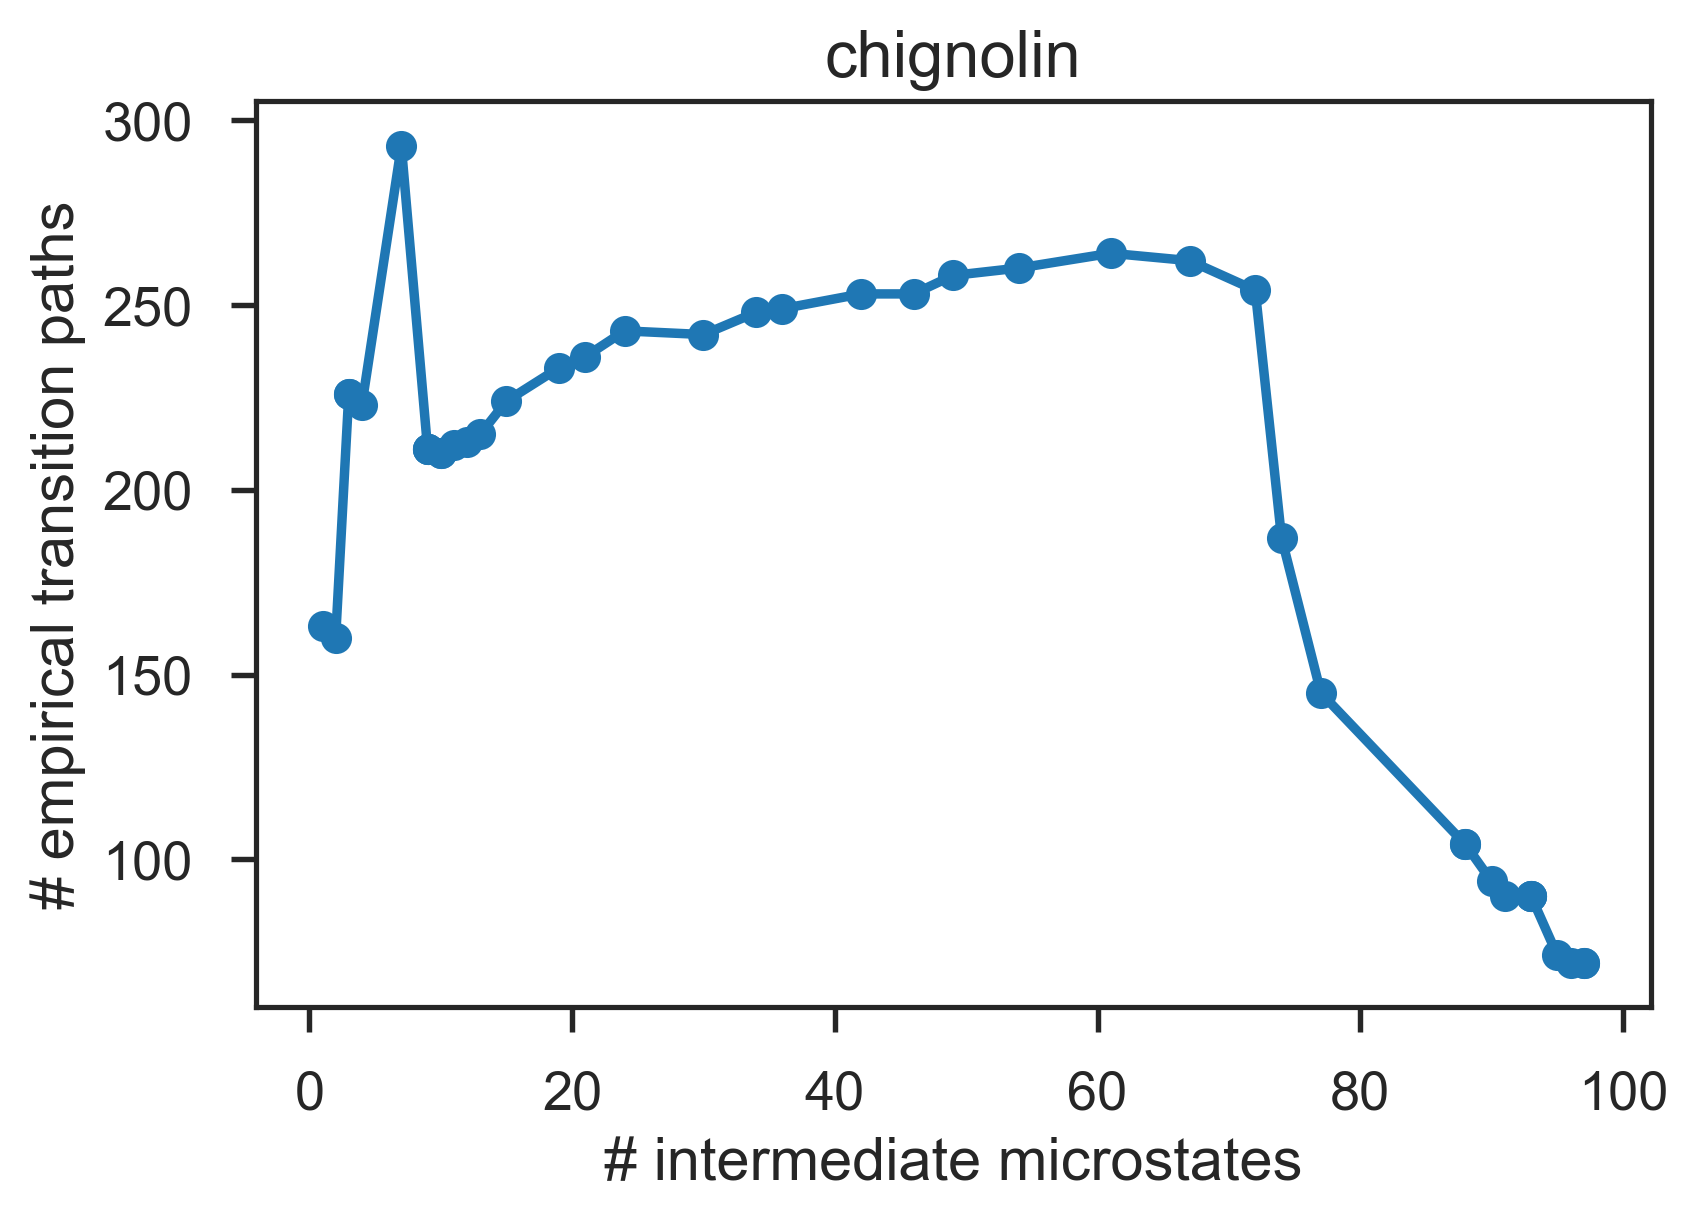

In [852]:
plt.figure(dpi=300)
plt.plot(intermediate_lens[1:], [len(x) for x in int_trajs_allints[1:]])
plt.scatter(intermediate_lens[1:], [len(x) for x in int_trajs_allints[1:]], s=50)
plt.xlabel('# intermediate microstates')
plt.ylabel('# empirical transition paths')
plt.title('chignolin')
plt.show()

In [848]:
# let's look at mean sizes of the 95% CIs

In [977]:
bootstrap_ci_sizes = []

for k,int_trajs in enumerate(int_trajs_allints[1:]):

    bootstrap_counts = []
    
    int_trajs_sorted = np.sort(list(set(np.concatenate(int_trajs))))

    for bootstrap in range(100):

        int_trajs_ = np.random.choice(int_trajs, 210)

        #int_trajs_ = [list(set(x)) for x in int_trajs_]
        
        counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_)])
        
        #counts = [counter[j] for j in sorted([i for i in counter])]
        
        counts = []
        for i in int_trajs_sorted:
            if i in counter:
                counts.append(counter[i])
            else:
                counts.append(0)

        counts = counts / np.sum(counts)

        bootstrap_counts.append(counts)

        print(bootstrap)

    bootstrap_ci_sizes.append(np.sum(np.percentile(bootstrap_counts, 95, axis=0) - np.percentile(bootstrap_counts, 5, axis=0))/len(bootstrap_counts[0]))
    
    print(k)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
5

16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
31
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
5

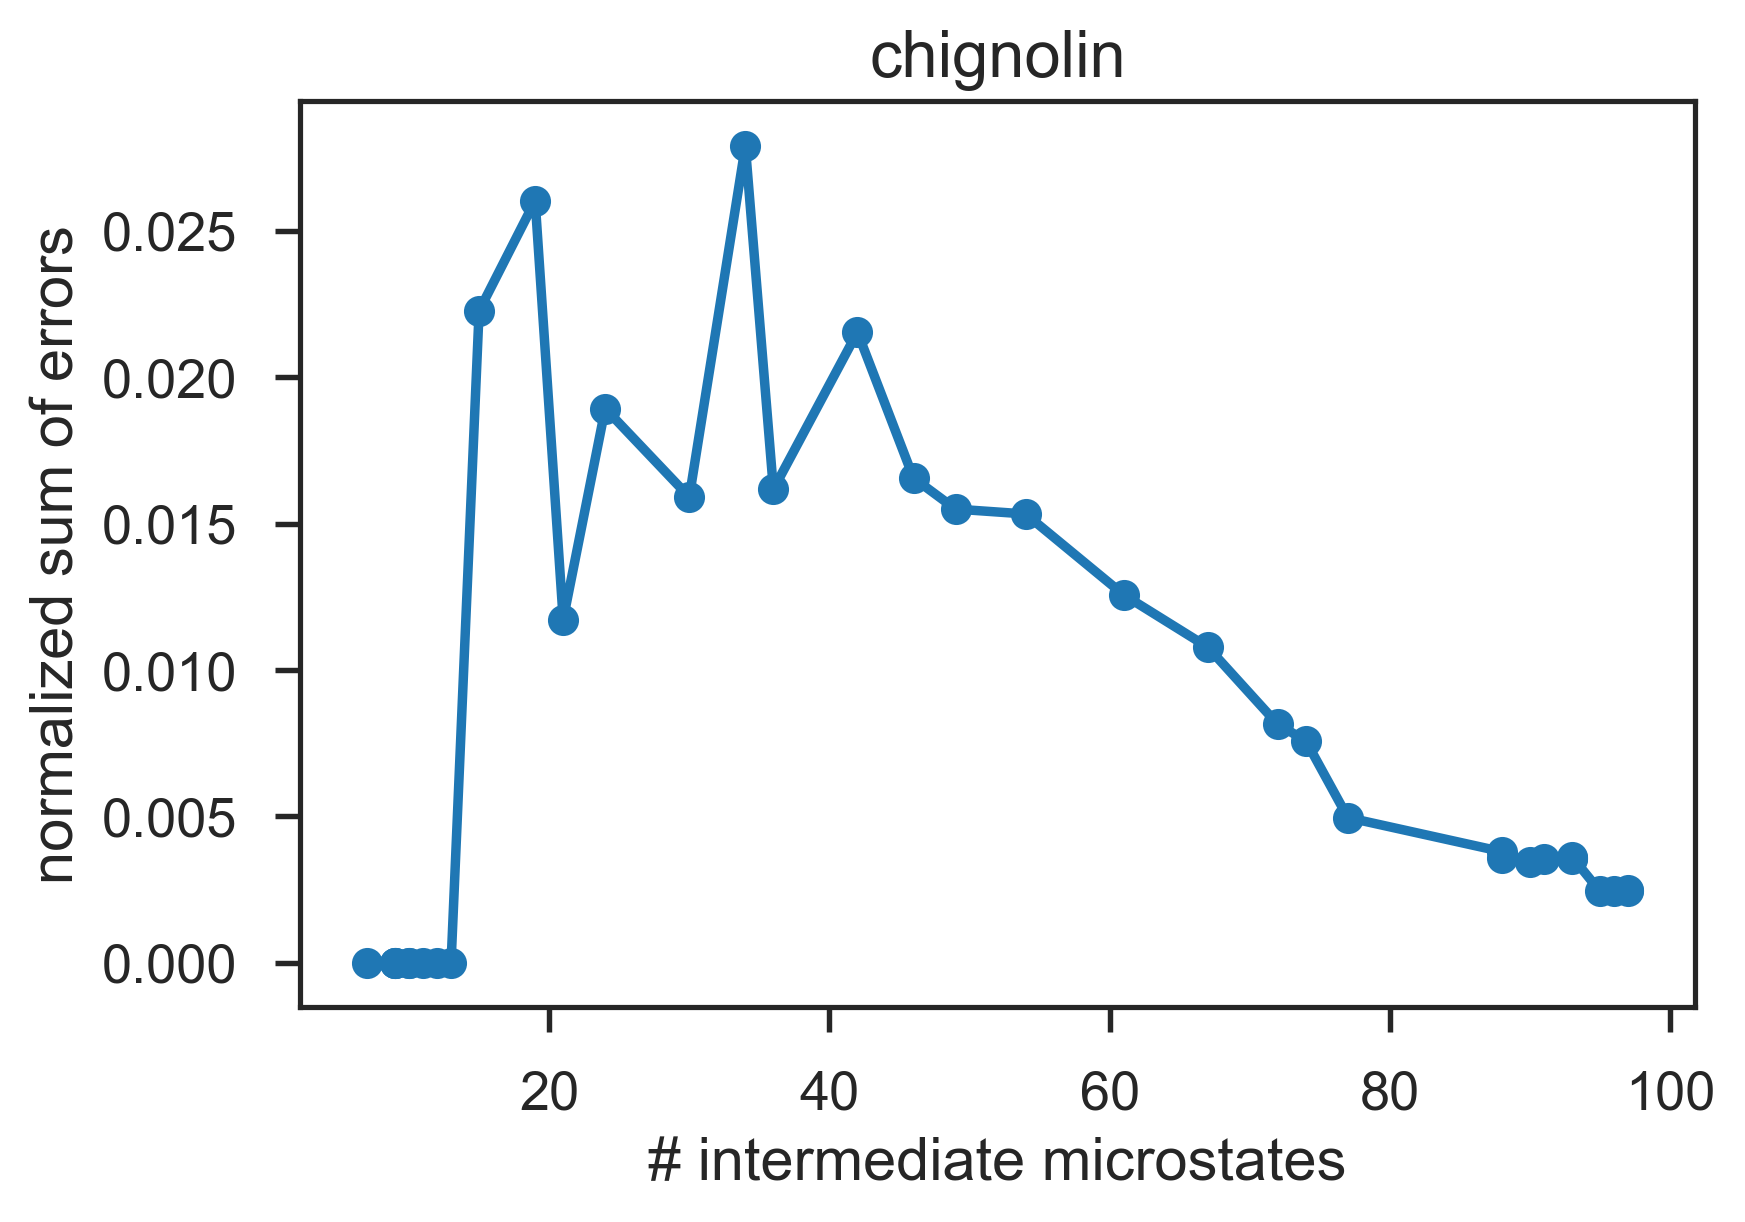

In [979]:
plt.figure(dpi=300)
plt.plot(intermediate_lens[1:], bootstrap_ci_sizes)
plt.scatter(intermediate_lens[1:], bootstrap_ci_sizes, s=50)
plt.xlabel('# intermediate microstates')
plt.ylabel(' sum of errors')
plt.title('chignolin')
plt.show()

In [38]:
# let's see the haMSMs

In [68]:
nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)

In [58]:
nm_model.nm_tmatrix.shape

(24, 24)

In [59]:
nm_model.markov_tmatrix.shape

(12, 12)

In [105]:
len(set(dtrajs[0]))

12

In [102]:
# plt.figure(dpi=300)
# #plt.imshow(np.log10(nm_model.nm_tmatrix), cmap='Blues')
# plt.imshow(nm_model.nm_tmatrix, cmap='Blues')
# plt.colorbar()

In [103]:
# plt.figure(dpi=300)
# #plt.imshow(np.log10(nm_model.markov_tmatrix), cmap='Blues')
# plt.imshow(nm_model.markov_tmatrix, cmap='Blues')
# plt.colorbar()

In [104]:
# y = dtrajs[0][::100]

# plt.figure(dpi=150)
# plt.scatter(range(len(y)),y, s=20)
# plt.show()

In [122]:
Counter(dtrajs[0])

Counter({0: 413292,
         1: 108574,
         5: 1371,
         14: 990,
         19: 1342,
         40: 1125,
         42: 1710,
         51: 883,
         60: 898,
         88: 2610,
         96: 1125,
         97: 823})

In [91]:
[x for x in list(range(100)) if x not in (stateA+stateB)]

[5, 14, 19, 40, 42, 51, 60, 88, 96, 97]

In [92]:
# ok so it replaces all microstates in stateA/stateB with 0/1, and keeps the intermediates

In [107]:
# let's simulate trajectories now - Ernesto provided solution how to

In [71]:
from nmm import DiscretePathEnsemble
from nmm import DiscreteEnsemble

In [78]:
my_path_ensembleAB = DiscretePathEnsemble.from_transition_matrix( nm_model.tmatrixAB(), nm_model.stateA, nm_model.stateB, n_paths=1000)

In [79]:
my_path_ensembleBA = DiscretePathEnsemble.from_transition_matrix( nm_model.tmatrixBA(), nm_model.stateB, nm_model.stateA, n_paths=1000)

In [128]:
nm_model.trajectories[0]

array([0, 1, 1, ..., 0, 0, 0])

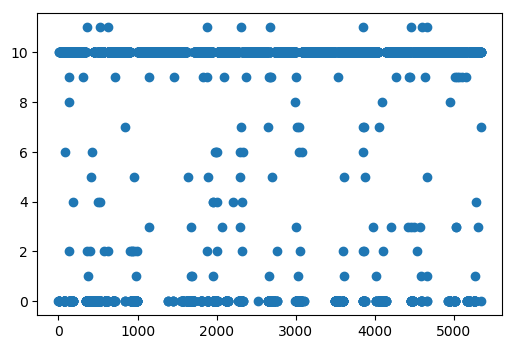

In [141]:
y = nm_model.trajectories[0][::100]

plt.figure(dpi=100)
plt.scatter(range(len(y)), y)
plt.show()

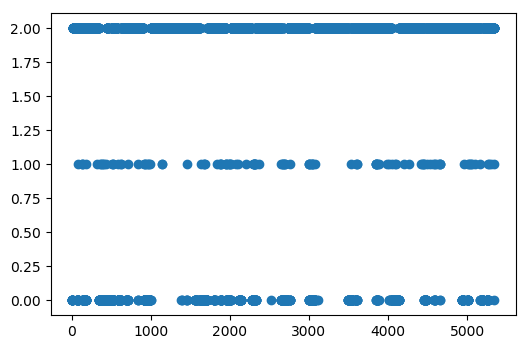

In [140]:
y = macro_traj[::100]

plt.figure(dpi=100)
plt.scatter(range(len(y)), y)
plt.show()

In [142]:
# ok so unfolded (stateA) is 0, folded (stateB) is 10, intermediates have been renumbered - let's see how

In [69]:
trans_dict = dict()

for i in range(len(dtrajs[0])):
    if dtrajs[0][i] in [x for x in list(range(100)) if x not in (stateA+stateB)]:
        if nm_model.trajectories[0][i] not in trans_dict:
            trans_dict[nm_model.trajectories[0][i]] = dtrajs[0][i]
    if len(trans_dict) == 10:
        break

In [151]:
trans_dict

{1: 40, 2: 5, 3: 42, 4: 14, 5: 97, 6: 60, 7: 96, 8: 51, 9: 88, 11: 19}

In [152]:
# ok so let's take the transition paths and translate, do my usual code

In [154]:
set(np.concatenate(my_path_ensembleAB.trajectories))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [14]:
len(my_path_ensembleAB.trajectories)

210

In [80]:
int_trajs_all_nm = []

for traj in my_path_ensembleAB.trajectories + my_path_ensembleBA.trajectories:
    int_trajs = []

    int_traj = []
    in_int = False
    int_start = None
    int_end = None
    for i in range(len(traj) - 1):
        if in_int:
            int_traj.append(traj[i])
            if traj[i+1] in [0,10]:
                in_int = False
                int_end = traj[i+1]
                if int_end != int_start:
                    int_trajs.append(int_traj)
                int_traj = []
        elif traj[i] in [0,10] and traj[i+1] in [x for x in range(12) if x not in [0,10]]:
            in_int = True
            int_start = traj[i]
            
    int_trajs_all_nm.append(int_trajs)        

In [81]:
# looks good - now translate to previous microstate numbers

In [82]:
int_trajs_nm = []

for x in int_trajs_all_nm:
    for traj in x:
        int_trajs_nm.append([])
        for i in traj:
            int_trajs_nm[-1].append(trans_dict[i])

In [83]:
len(int_trajs_nm)

1014

In [174]:
# some paths have no-intermediate transitions

In [84]:
int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_nm)])
counts = [counter[i] for i in range(10)]
counts = np.array(counts) / np.sum(counts)

counts_all_nm = counts

In [85]:
counts

array([0.11288305, 0.10553471, 0.13586617, 0.0756723 , 0.11647905,
       0.11163227, 0.05644153, 0.12148218, 0.08849281, 0.07551595])

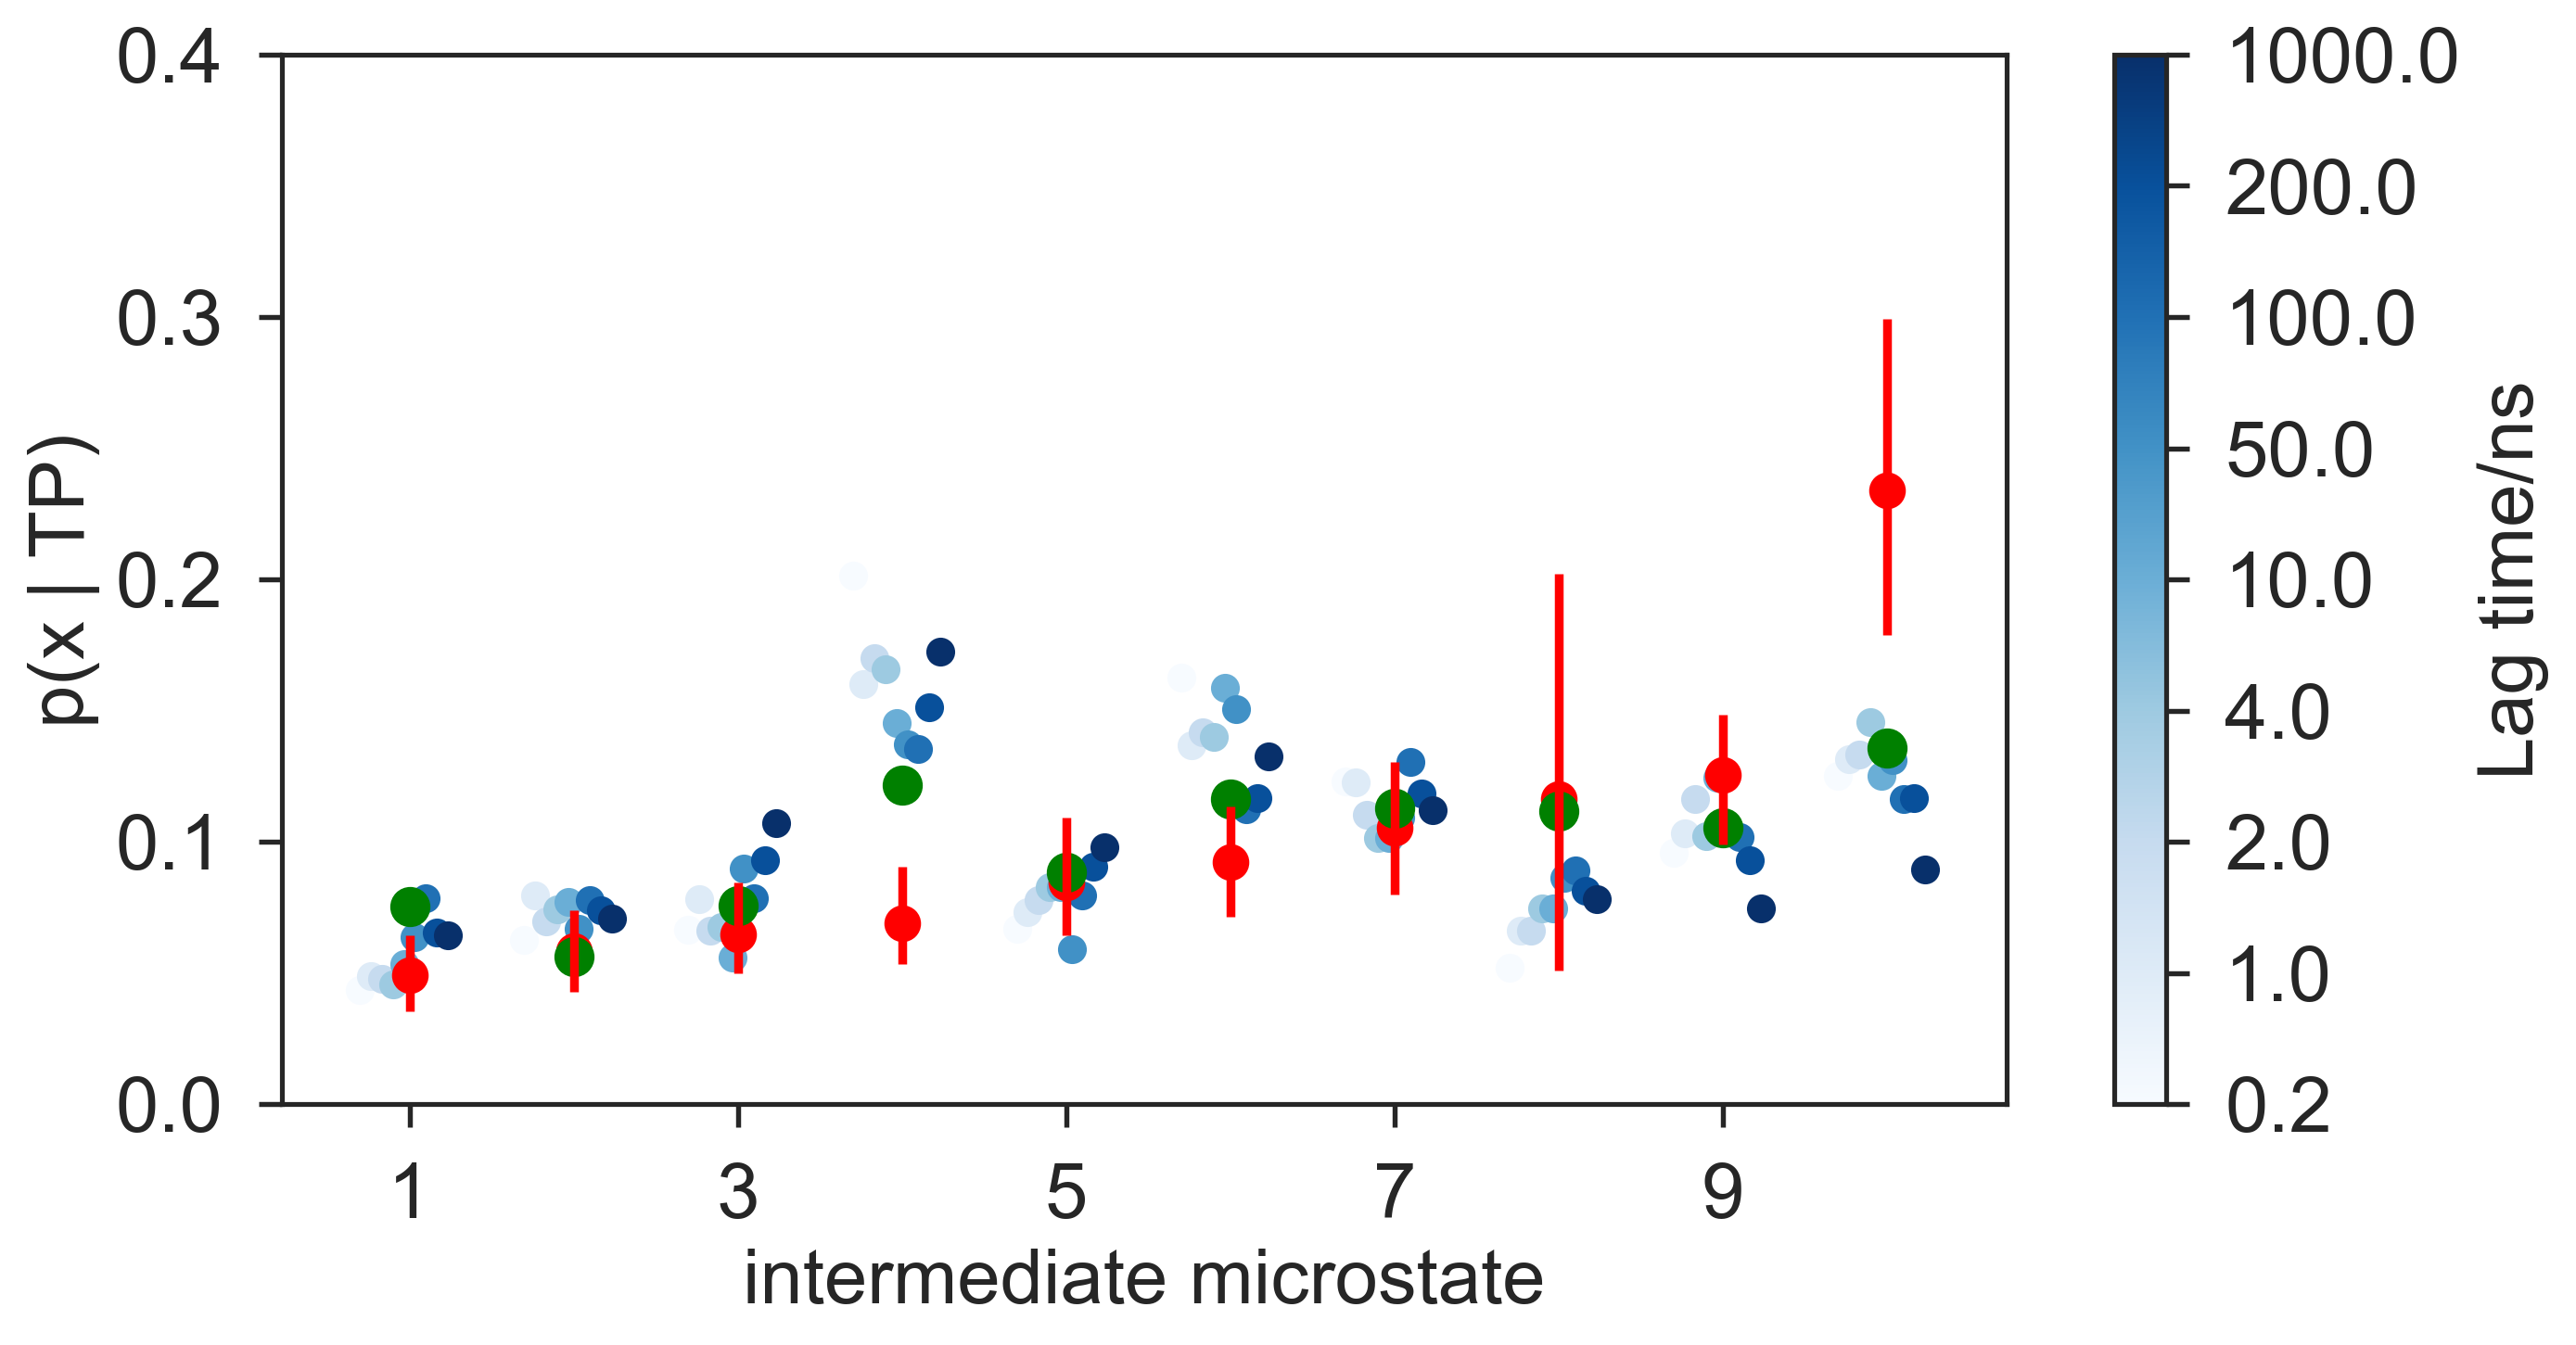

In [86]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Blues)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index][np.argsort(np.mean(boostrap_counts, axis=0))], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('Lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.scatter(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='red')
plt.errorbar(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[(np.mean(boostrap_counts, axis=0)-np.percentile(boostrap_counts, 5, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))], (np.percentile(boostrap_counts, 95, axis=0)-np.mean(boostrap_counts, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='red')
plt.scatter(np.arange(1,11), counts_all_nm[np.argsort(np.mean(boostrap_counts, axis=0))], color='green', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x | TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0, 0.5, 0.1), fontsize=20)

plt.show()

In [115]:
boostrap_counts = []

int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

for boostrap in range(1000):

    int_trajs_ = np.random.choice(int_trajs, 210)

    counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_)])
    
    counts = [counter[i] for i in range(10)]

    counts = counts / np.sum(counts)
    
    boostrap_counts.append(counts)
    
    #print(boostrap)

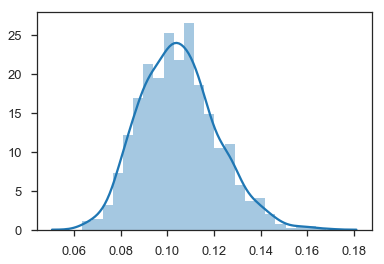

In [131]:
sns.distplot(np.array(boostrap_counts)[:,0])

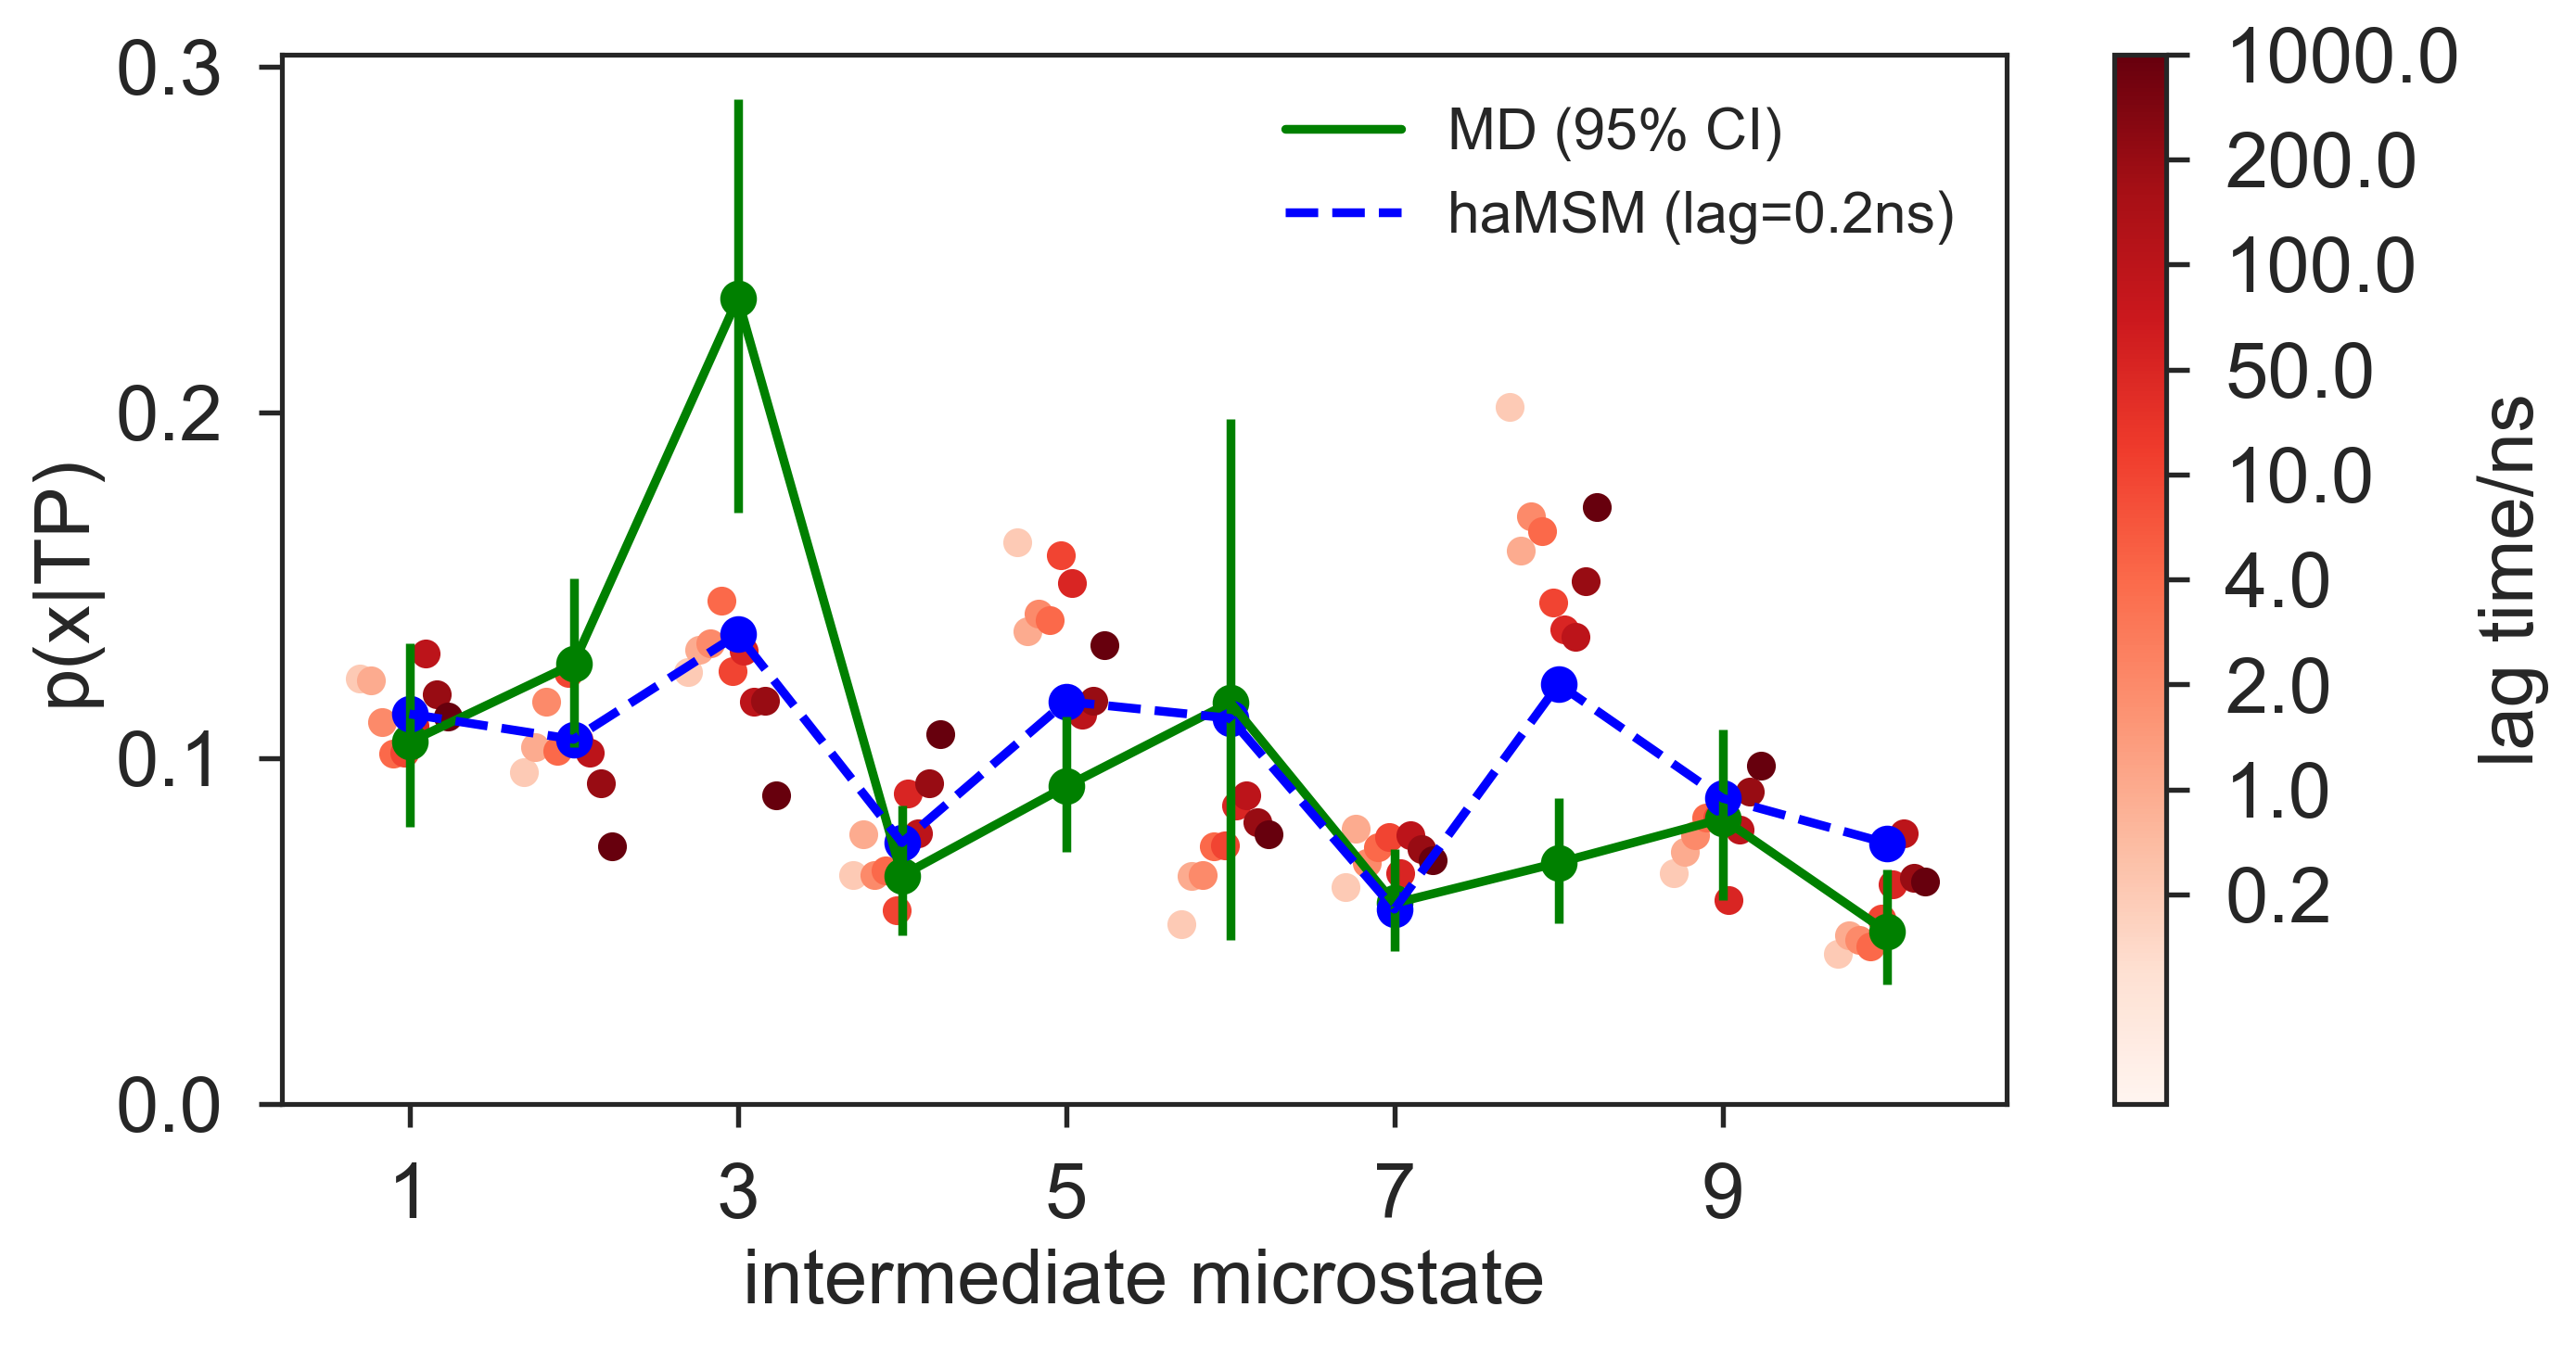

In [134]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    #plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index][np.argsort(np.mean(boostrap_counts, axis=0))], color=cmap.to_rgba(msm_index), s=50)
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.scatter(range(1,11), np.mean(boostrap_counts, axis=0), color='green')
plt.plot(range(1,11), np.mean(boostrap_counts, axis=0), color='green', label='MD (95% CI)')
plt.errorbar(range(1,11), np.mean(boostrap_counts, axis=0), yerr=[(np.mean(boostrap_counts, axis=0)-np.percentile(boostrap_counts, 5, axis=0)), (np.percentile(boostrap_counts, 95, axis=0)-np.mean(boostrap_counts, axis=0))], fmt='none', color='green')

plt.scatter(np.arange(1,11), counts_all_nm, color='blue')
plt.plot(np.arange(1,11), counts_all_nm, '--', color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0, 0.4, 0.1), fontsize=20)
plt.legend(prop={'size':15})

plt.show()

In [116]:
# interesting - two microstates that both MSM and haMSMs get wrong -- let's bootstrap errors for the haMSMs

In [117]:
boostrap_counts_nm = []

int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

for boostrap in range(100):

    int_trajs_ = np.random.choice(int_trajs_nm, len(int_trajs_nm))

    counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_)])
    
    counts = [counter[i] for i in range(10)]

    counts = counts / np.sum(counts)
    
    boostrap_counts_nm.append(counts)

In [141]:
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

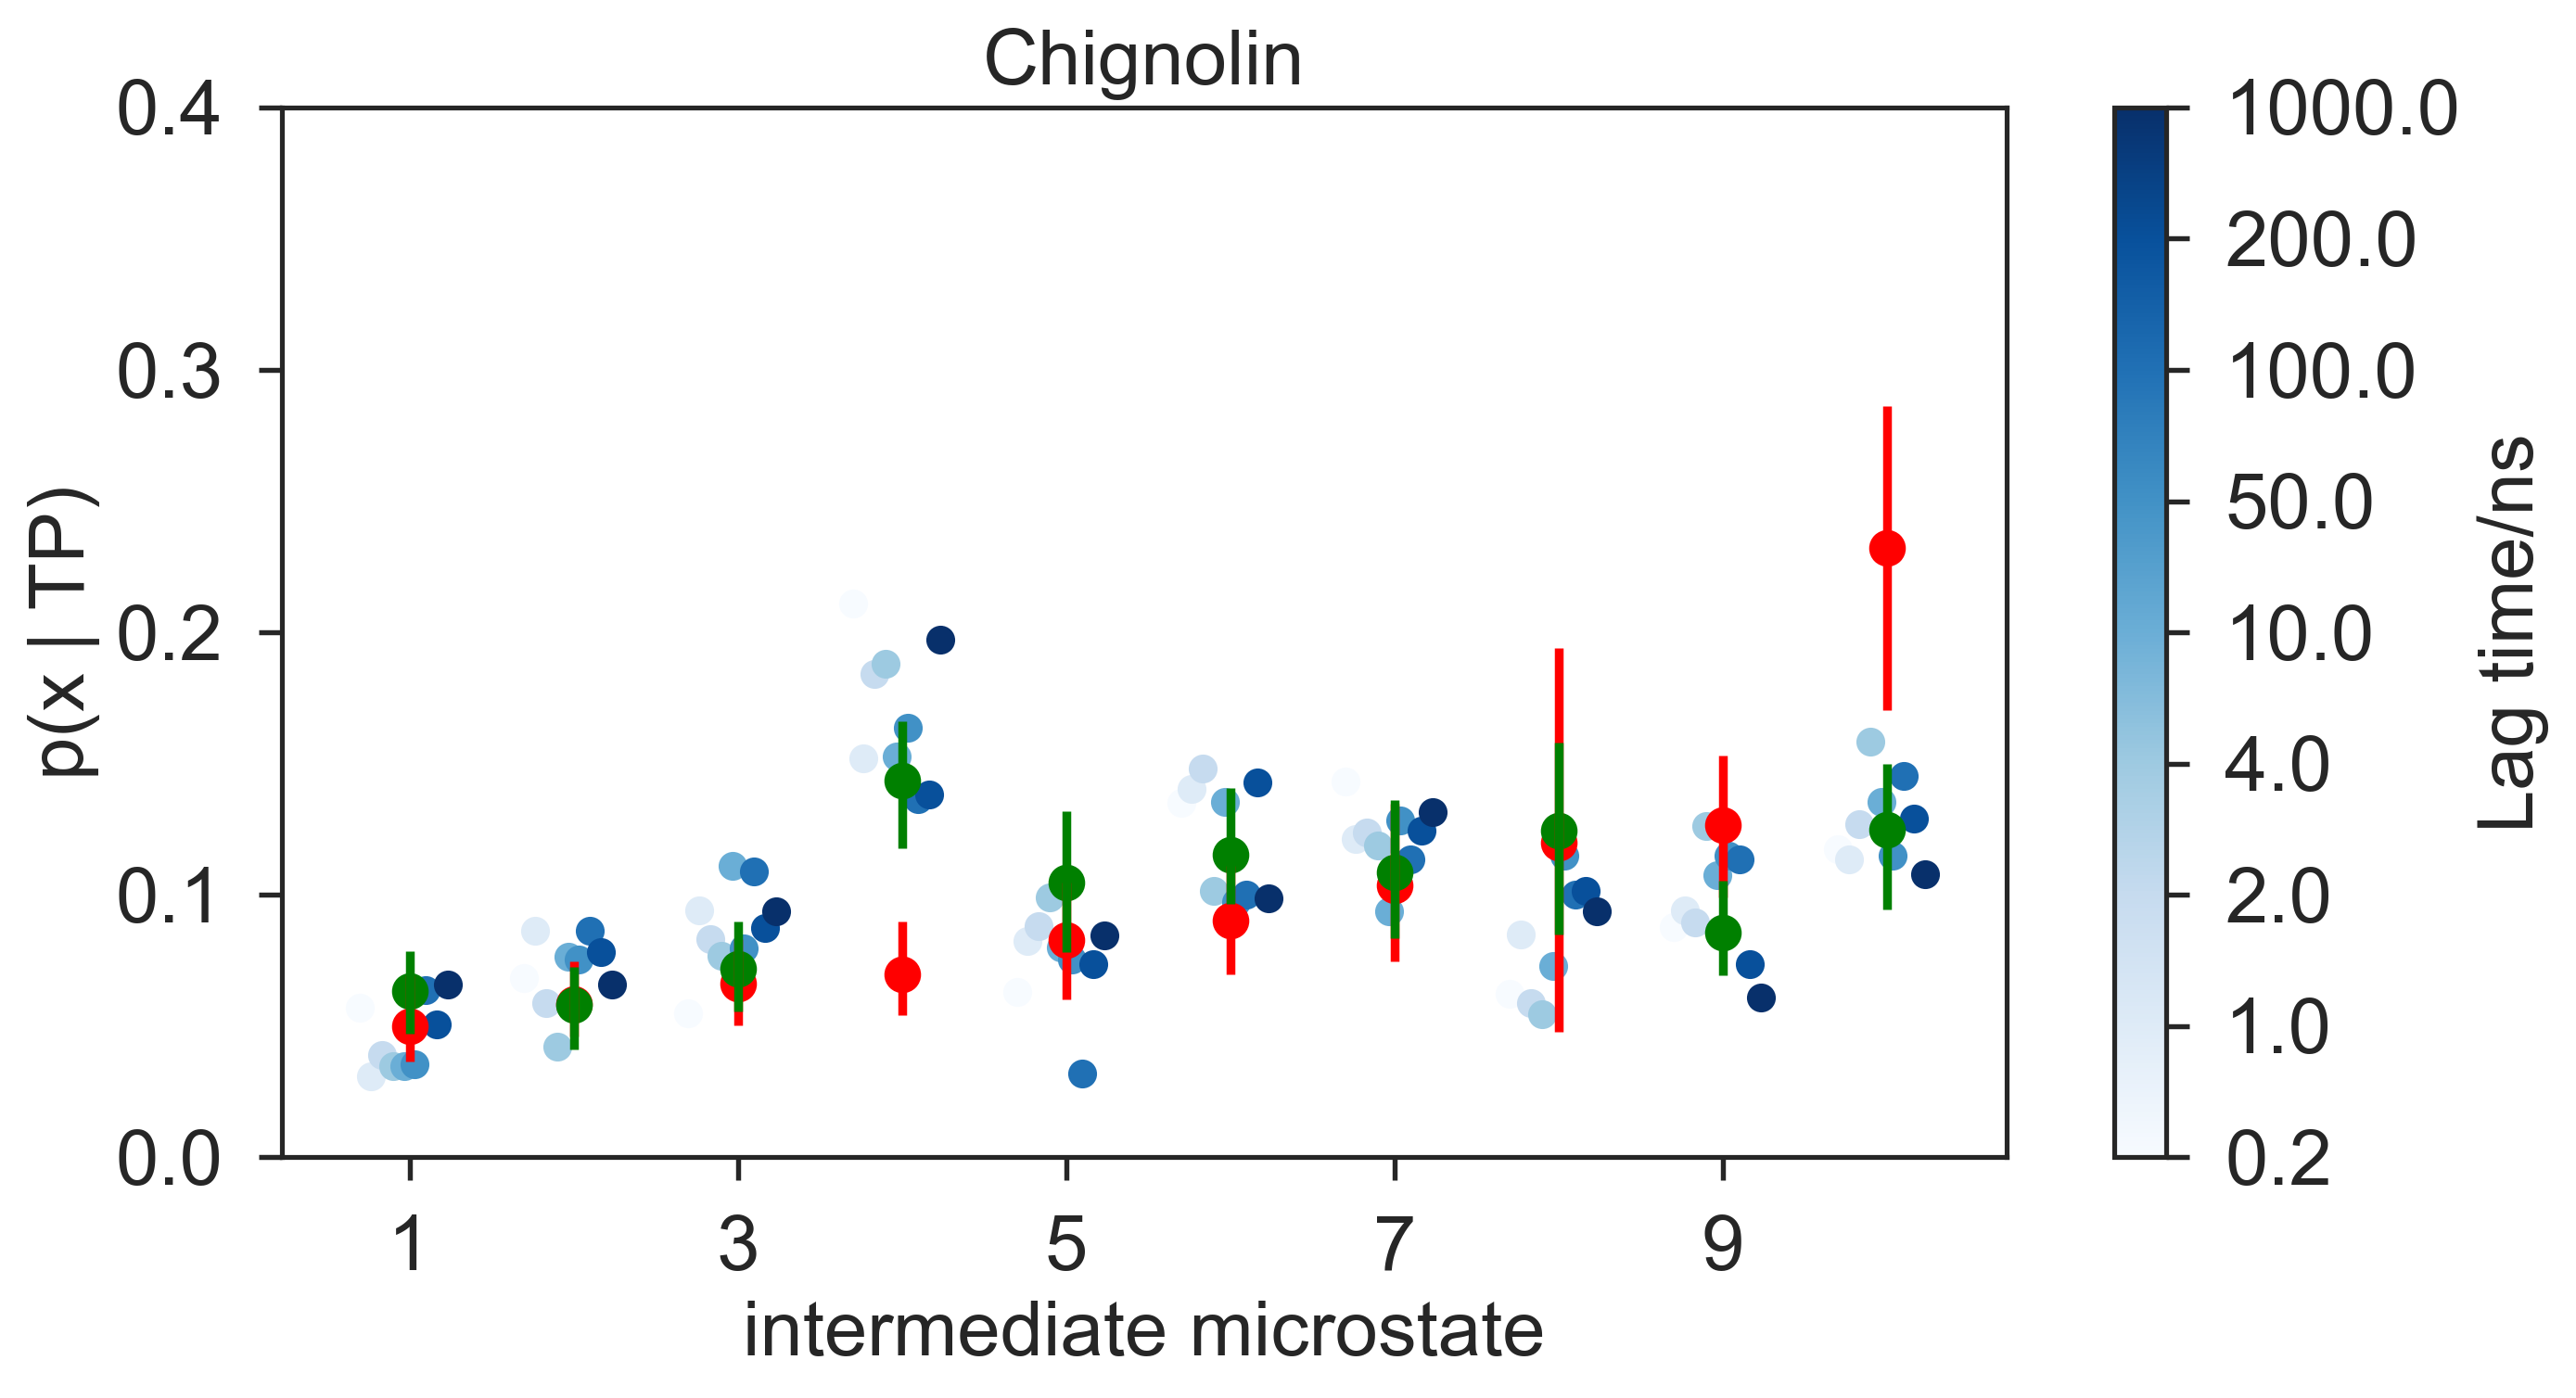

In [144]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Blues)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index][np.argsort(np.mean(boostrap_counts, axis=0))], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('Lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.scatter(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='red')
plt.errorbar(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[(np.mean(boostrap_counts, axis=0)-np.percentile(boostrap_counts, 5, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))], (np.percentile(boostrap_counts, 95, axis=0)-np.mean(boostrap_counts, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='red')

#plt.scatter(np.arange(1,11), counts_all_nm[np.argsort(np.mean(boostrap_counts, axis=0))], color='green', s=100)
plt.scatter(range(1,11), np.mean(boostrap_counts_nm, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='green')
plt.errorbar(range(1,11), np.mean(boostrap_counts_nm, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[(np.mean(boostrap_counts_nm, axis=0)-np.percentile(boostrap_counts_nm, 5, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))], (np.percentile(boostrap_counts_nm, 95, axis=0)-np.mean(boostrap_counts_nm, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='green')

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x | TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0, 0.5, 0.1), fontsize=20)
plt.title('Chignolin', fontsize=20)

plt.show()

In [145]:
# try limited-history haMSM

In [149]:
m_p_color = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True, hist_length=100)

In [150]:
my_path_ensembleAB = DiscretePathEnsemble.from_transition_matrix( m_p_color.tmatrixAB(), m_p_color.stateA, m_p_color.stateB, n_paths=210)

In [151]:
my_path_ensembleBA = DiscretePathEnsemble.from_transition_matrix( m_p_color.tmatrixBA(), m_p_color.stateB, m_p_color.stateA, n_paths=210)

In [157]:
m_p_color.stateA, m_p_color.stateB

([0], [10])

In [158]:
int_trajs_all_nm = []

for traj in my_path_ensembleAB.trajectories + my_path_ensembleBA.trajectories:
    int_trajs = []

    int_traj = []
    in_int = False
    int_start = None
    int_end = None
    for i in range(len(traj) - 1):
        if in_int:
            int_traj.append(traj[i])
            if traj[i+1] in [0,10]:
                in_int = False
                int_end = traj[i+1]
                if int_end != int_start:
                    int_trajs.append(int_traj)
                int_traj = []
        elif traj[i] in [0,10] and traj[i+1] in [x for x in range(12) if x not in [0,10]]:
            in_int = True
            int_start = traj[i]
            
    int_trajs_all_nm.append(int_trajs)        

In [159]:
trans_dict = dict()

for i in range(len(dtrajs[0])):
    if dtrajs[0][i] in [x for x in list(range(100)) if x not in (stateA+stateB)]:
        if m_p_color.trajectories[0][i] not in trans_dict:
            trans_dict[m_p_color.trajectories[0][i]] = dtrajs[0][i]
    if len(trans_dict) == 10:
        break

In [160]:
int_trajs_nm = []

for x in int_trajs_all_nm:
    for traj in x:
        int_trajs_nm.append([])
        for i in traj:
            int_trajs_nm[-1].append(trans_dict[i])

In [161]:
len(int_trajs_nm)

226

In [162]:
boostrap_counts_nm2 = []

int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

for boostrap in range(100):

    int_trajs_ = np.random.choice(int_trajs_nm, len(int_trajs_nm))

    counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_)])
    
    counts = [counter[i] for i in range(10)]

    counts = counts / np.sum(counts)
    
    boostrap_counts_nm2.append(counts)

In [ ]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Blues)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index][np.argsort(np.mean(boostrap_counts, axis=0))], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('Lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.scatter(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='red')
plt.errorbar(range(1,11), np.mean(boostrap_counts, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[(np.mean(boostrap_counts, axis=0)-np.percentile(boostrap_counts, 5, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))], (np.percentile(boostrap_counts, 95, axis=0)-np.mean(boostrap_counts, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='red')

plt.scatter(range(1,11), np.mean(boostrap_counts_nm, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='green', s=120)
#plt.errorbar(range(1,11), np.mean(boostrap_counts_nm, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[(np.mean(boostrap_counts_nm, axis=0)-np.percentile(boostrap_counts_nm, 5, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))], (np.percentile(boostrap_counts_nm, 95, axis=0)-np.mean(boostrap_counts_nm, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='green')

plt.scatter(range(1,11), np.mean(boostrap_counts_nm2, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], color='yellow', s=120)
#plt.errorbar(range(1,11), np.mean(boostrap_counts_nm2, axis=0)[np.argsort(np.mean(boostrap_counts, axis=0))], yerr=[(np.mean(boostrap_counts_nm2, axis=0)-np.percentile(boostrap_counts_nm2, 5, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))], (np.percentile(boostrap_counts_nm2, 95, axis=0)-np.mean(boostrap_counts_nm2, axis=0))[np.argsort(np.mean(boostrap_counts, axis=0))]], fmt='none', color='yellow')

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x | TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0, 0.5, 0.1), fontsize=20)
plt.title('Chignolin', fontsize=20)

plt.show()